# Iris - MLP

### [Dataset](https://www.kaggle.com/datasets/himanshunakrani/iris-dataset)

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

License: MIT

## Install Libraries

In [1]:
# !python -m pip install --upgrade pip
# %pip install ipywidgets
# %pip install pandas matplotlib seaborn
# %pip install scikit-learn
# # %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124  # Windows with CUDA 12.4
# %pip install torch  # MacOS or CPU-only
# %pip install shap
# %pip install black
# %pip install black[jupyter]
# %pip install nbqa
# %pip install scipy

## Import Libraries

In [2]:
import warnings
import sqlite3
from itertools import combinations
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from scipy import stats
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    normalized_mutual_info_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore", message=".*global RNG.*", category=FutureWarning)

## Seed

In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

## Device

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
DEVICE

device(type='mps')

## Parameters

In [5]:
H1 = 8
H2 = 8
OUT_FEATURES = 3
TEST_SIZE = 0.3
DATA_PATH = "iris.csv"
TARGET_VAR = "species"
CLASS_NAMES = ["Setosa", "Versicolor", "Virginica"]
SPECIES_MAP = {0: "setosa", 1: "versicolor", 2: "virginica"}

## Hyperparameters

In [6]:
LR = 0.01
EPOCHS = 1000
LOG_INTERVAL = 10
BATCH_SIZE = 32
CHUNK_SIZE = None  # Set to int (e.g., 100000) for large files, None for small files
DROPOUT = 0.0  # Dropout rate (0.0 = no dropout, 0.2-0.5 typical for regularization)
VAL_SIZE = 0.15  # Fraction of training data reserved for validation
PATIENCE = 50  # Early stopping patience (epochs without improvement)

## Load Dataset

In [7]:
if CHUNK_SIZE is None:
    df = pd.read_csv(DATA_PATH)
else:
    chunks = []
    for chunk in pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE):
        chunks.append(chunk)
    df = pd.concat(chunks, ignore_index=True)
    del chunks  # Free memory
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Clean Dataset

### Complete Missingness Analysis

In [9]:
missing_df = pd.DataFrame(
    {
        "Variable": df.columns,
        "Missing_Count": df.isna().sum(),
        "Missing_Pct": (df.isna().sum() / len(df) * 100).round(1),
    }
).sort_values("Missing_Pct", ascending=False)
missing_df

,Variable,Missing_Count,Missing_Pct
sepal_length,sepal_length,0,0.0
sepal_width,sepal_width,0,0.0
petal_length,petal_length,0,0.0
petal_width,petal_width,0,0.0
species,species,0,0.0


### Create Dataset `df_clean` w/ Cleaned Data

In [10]:
df_clean = df.copy()
df_clean

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### Drop Variables in `df_clean` w/ Missings

In [11]:
# df_clean.drop(columns=[
#     "",
#     ""],
#     inplace=True)

### Drop Variables w/ No Predictive Value

In [12]:
# df_clean.drop(columns=[
#     "",
#     ""],
#     inplace=True)

## Feature Engineering

### Classify `petal_shape` If `petal_length` > 3x `petal_width`

In [13]:
df_clean["petal_shape"] = np.where(
    (df_clean["petal_length"] / df_clean["petal_width"]) > 3.0, "elongated", "round"
)
df_clean["petal_shape"]

0      elongated
1      elongated
2      elongated
3      elongated
4      elongated
         ...    
145        round
146        round
147        round
148        round
149        round
Name: petal_shape, Length: 150, dtype: object

### Classify `sepal_dominance`, If `sepal_length` > 2x `petal_length`

In [14]:
df_clean["sepal_dominance"] = np.where(
    df_clean["sepal_length"] > (2 * df_clean["petal_length"]),
    "sepal_dominant",
    "balanced",
)
df_clean["sepal_dominance"]

0      sepal_dominant
1      sepal_dominant
2      sepal_dominant
3      sepal_dominant
4      sepal_dominant
            ...      
145          balanced
146          balanced
147          balanced
148          balanced
149          balanced
Name: sepal_dominance, Length: 150, dtype: object

## Save Cleaned Dataset

In [15]:
df_clean.to_csv("iris_dataset_clean.csv", index=False)

## Load Cleaned Dataset

In [16]:
df_eda = pd.read_csv("iris_dataset_clean.csv")
df_eda

,sepal_length,sepal_width,petal_length,petal_width,species,petal_shape,sepal_dominance
0,5.1,3.5,1.4,0.2,setosa,elongated,sepal_dominant
1,4.9,3.0,1.4,0.2,setosa,elongated,sepal_dominant
2,4.7,3.2,1.3,0.2,setosa,elongated,sepal_dominant
3,4.6,3.1,1.5,0.2,setosa,elongated,sepal_dominant
4,5.0,3.6,1.4,0.2,setosa,elongated,sepal_dominant
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,round,balanced
146,6.3,2.5,5.0,1.9,virginica,round,balanced
147,6.5,3.0,5.2,2.0,virginica,round,balanced
148,6.2,3.4,5.4,2.3,virginica,round,balanced


## SQL Exploration

In [17]:
# Create in-memory SQLite database from cleaned Iris dataset
conn = sqlite3.connect(":memory:")
df_eda.to_sql("iris", conn, index=False, if_exists="replace")

150

### Helper Function for Query Execution

In [18]:
def run_query(query, description, n_rows=20):
    """
    Execute a SQL query against the in-memory SQLite database and display results.

    Parameters:
        query (str): SQL query string to execute.
        description (str): Human-readable description of what the query does.
        n_rows (int): Maximum number of rows to display (default: 20).

    Returns:
        None
    """
    print(f"\n{'='*80}")
    print(f"QUERY: {description}")
    print(f"{'='*80}")
    print(f"\nSQL:\n{query}\n")
    result = pd.read_sql_query(query, conn)
    print(f"Results ({len(result)} rows):")
    display(result.head(n_rows))

### Species Distribution

Understand the distribution of `species` across the Iris dataset.

In [19]:
query = """
SELECT
    species,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM iris), 2) as percentage
FROM iris
GROUP BY species
ORDER BY count DESC;
"""
run_query(query, "Overall species distribution")


QUERY: Overall species distribution

SQL:

SELECT
    species,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM iris), 2) as percentage
FROM iris
GROUP BY species
ORDER BY count DESC;


Results (3 rows):


,species,count,percentage
0,virginica,50,33.33
1,versicolor,50,33.33
2,setosa,50,33.33


### Feature Statistics by Species

What are the average measurements for each `species`?

In [20]:
query = """
SELECT
    species,
    ROUND(AVG(sepal_length), 2) as avg_sepal_length,
    ROUND(AVG(sepal_width), 2) as avg_sepal_width,
    ROUND(AVG(petal_length), 2) as avg_petal_length,
    ROUND(AVG(petal_width), 2) as avg_petal_width,
    COUNT(*) as sample_count
FROM iris
GROUP BY species
ORDER BY species;
"""
run_query(query, "Average feature measurements by species")


QUERY: Average feature measurements by species

SQL:

SELECT
    species,
    ROUND(AVG(sepal_length), 2) as avg_sepal_length,
    ROUND(AVG(sepal_width), 2) as avg_sepal_width,
    ROUND(AVG(petal_length), 2) as avg_petal_length,
    ROUND(AVG(petal_width), 2) as avg_petal_width,
    COUNT(*) as sample_count
FROM iris
GROUP BY species
ORDER BY species;


Results (3 rows):


,species,avg_sepal_length,avg_sepal_width,avg_petal_length,avg_petal_width,sample_count
0,setosa,5.01,3.42,1.46,0.24,50
1,versicolor,5.94,2.77,4.26,1.33,50
2,virginica,6.59,2.97,5.55,2.03,50


### Petal Shape Distribution by Species

How does the engineered `petal_shape` feature distribute across `species`?

In [21]:
query = """
SELECT
    species,
    petal_shape,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY species), 2) as pct_within_species
FROM iris
GROUP BY species, petal_shape
ORDER BY species, petal_shape;
"""
run_query(query, "Petal shape distribution by species")


QUERY: Petal shape distribution by species

SQL:

SELECT
    species,
    petal_shape,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY species), 2) as pct_within_species
FROM iris
GROUP BY species, petal_shape
ORDER BY species, petal_shape;


Results (6 rows):


,species,petal_shape,count,pct_within_species
0,setosa,elongated,49,98.0
1,setosa,round,1,2.0
2,versicolor,elongated,37,74.0
3,versicolor,round,13,26.0
4,virginica,elongated,16,32.0
5,virginica,round,34,68.0


### Sepal Dominance Distribution by Species

How does the engineered `sepal_dominance` feature distribute across `species`?

In [22]:
query = """
SELECT
    species,
    sepal_dominance,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY species), 2) as pct_within_species
FROM iris
GROUP BY species, sepal_dominance
ORDER BY species, sepal_dominance;
"""
run_query(query, "Sepal dominance distribution by species")


QUERY: Sepal dominance distribution by species

SQL:

SELECT
    species,
    sepal_dominance,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY species), 2) as pct_within_species
FROM iris
GROUP BY species, sepal_dominance
ORDER BY species, sepal_dominance;


Results (3 rows):


,species,sepal_dominance,count,pct_within_species
0,setosa,sepal_dominant,50,100.0
1,versicolor,balanced,50,100.0
2,virginica,balanced,50,100.0


### Feature Ranges by Species

What are the min/max feature values for each `species`?

In [23]:
query = """
SELECT
    species,
    MIN(petal_length) as min_petal_length,
    MAX(petal_length) as max_petal_length,
    MIN(petal_width) as min_petal_width,
    MAX(petal_width) as max_petal_width,
    MIN(sepal_length) as min_sepal_length,
    MAX(sepal_length) as max_sepal_length
FROM iris
GROUP BY species
ORDER BY species;
"""
run_query(query, "Feature ranges by species")


QUERY: Feature ranges by species

SQL:

SELECT
    species,
    MIN(petal_length) as min_petal_length,
    MAX(petal_length) as max_petal_length,
    MIN(petal_width) as min_petal_width,
    MAX(petal_width) as max_petal_width,
    MIN(sepal_length) as min_sepal_length,
    MAX(sepal_length) as max_sepal_length
FROM iris
GROUP BY species
ORDER BY species;


Results (3 rows):


,species,min_petal_length,max_petal_length,min_petal_width,max_petal_width,min_sepal_length,max_sepal_length
0,setosa,1.0,1.9,0.1,0.6,4.3,5.8
1,versicolor,3.0,5.1,1.0,1.8,4.9,7.0
2,virginica,4.5,6.9,1.4,2.5,4.9,7.9


### Species Identification Patterns

Which features best identify each `species`?

In [24]:
query = """
SELECT
    species,
    COUNT(*) as total,
    SUM(CASE WHEN petal_length < 2.5 THEN 1 ELSE 0 END) as short_petal,
    ROUND(SUM(CASE WHEN petal_length < 2.5 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as short_petal_pct,
    SUM(CASE WHEN sepal_dominance = 'sepal_dominant' THEN 1 ELSE 0 END) as sepal_dominant_count,
    ROUND(SUM(CASE WHEN sepal_dominance = 'sepal_dominant' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as sepal_dominant_pct
FROM iris
GROUP BY species
ORDER BY species;
"""
run_query(query, "Species identification patterns")


QUERY: Species identification patterns

SQL:

SELECT
    species,
    COUNT(*) as total,
    SUM(CASE WHEN petal_length < 2.5 THEN 1 ELSE 0 END) as short_petal,
    ROUND(SUM(CASE WHEN petal_length < 2.5 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as short_petal_pct,
    SUM(CASE WHEN sepal_dominance = 'sepal_dominant' THEN 1 ELSE 0 END) as sepal_dominant_count,
    ROUND(SUM(CASE WHEN sepal_dominance = 'sepal_dominant' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as sepal_dominant_pct
FROM iris
GROUP BY species
ORDER BY species;


Results (3 rows):


,species,total,short_petal,short_petal_pct,sepal_dominant_count,sepal_dominant_pct
0,setosa,50,50,100.0,50,100.0
1,versicolor,50,0,0.0,0,0.0
2,virginica,50,0,0.0,0,0.0


In [25]:
conn.close()

## Exploratory Data Analysis

In [26]:
df_eda.dtypes

sepal_length       float64
sepal_width        float64
petal_length       float64
petal_width        float64
species             object
petal_shape         object
sepal_dominance     object
dtype: object

### Create `CATEGORICAL_FEATURES` & `CONTINUOUS_FEATURES`

In [27]:
CATEGORICAL_FEATURES = ["petal_shape", "sepal_dominance"]
CATEGORICAL_FEATURES

['petal_shape', 'sepal_dominance']

In [28]:
CONTINUOUS_FEATURES = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
CONTINUOUS_FEATURES

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

### Create `TARGET_VARS`

In [29]:
TARGET_VARS_list = df_clean[TARGET_VAR].value_counts()
TARGET_VARS = TARGET_VARS_list.index.tolist()
TARGET_VARS

['setosa', 'versicolor', 'virginica']

### Verify Class Balance

In [30]:
# Verify class balance (important: accuracy is misleading if imbalanced)
print("Class Distribution:")
print(TARGET_VARS_list)
print(f"\nPercentages:")
print((TARGET_VARS_list / TARGET_VARS_list.sum() * 100).round(1).astype(str) + "%")
# Balance ratio: min_class / max_class (1.0 = perfect, <0.5 = significantly imbalanced)
balance_ratio = TARGET_VARS_list.min() / TARGET_VARS_list.max()
print(f"\nBalance Ratio: {balance_ratio:.2f}")
if balance_ratio >= 0.8:
    print("Assessment: Well-Balanced \u2705")
elif balance_ratio >= 0.5:
    print("Assessment: Moderately Imbalanced (consider stratified sampling)")
else:
    print("Assessment: Severely Imbalanced (use F1/AUC over accuracy, consider SMOTE)")

Class Distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Percentages:
species
setosa        33.3%
versicolor    33.3%
virginica     33.3%
Name: count, dtype: object

Balance Ratio: 1.00
Assessment: Well-Balanced ✅


### Visualize the Marginal Distributions

#### Count Plots — Marginal Distributions of Each Categorical Variable, w/ Facets for Each Categorical Variable

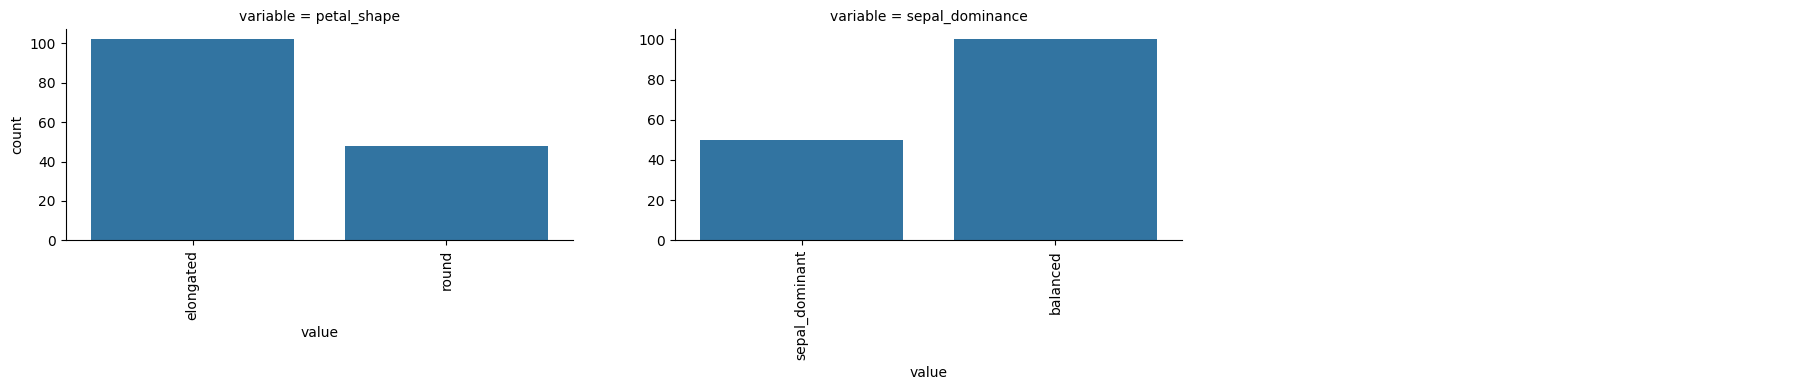

In [31]:
grid = sns.catplot(
    data=df_eda.melt(value_vars=CATEGORICAL_FEATURES),
    x="value",
    col="variable",
    col_wrap=3,
    kind="count",
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.5,
)
for ax in grid.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_ha("center")
grid.figure.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

#### Count Plots with Facets - Explore Relationships Between Categorical Variables

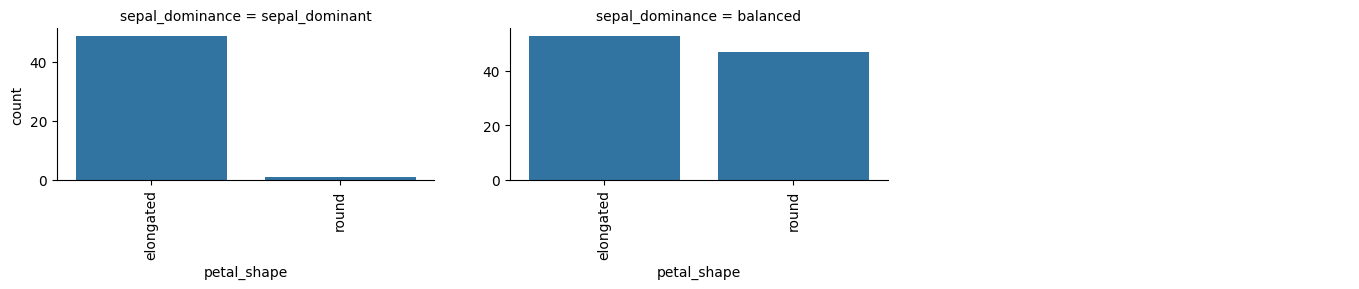

In [32]:
pairs = list(combinations(CATEGORICAL_FEATURES, 2))
for x_var, col_var in pairs:
    grid = sns.catplot(
        data=df_eda,
        x=x_var,
        col=col_var,
        col_wrap=3,
        kind="count",
        sharex=False,
        sharey=False,
        height=3,
        aspect=1.5,
    )
    for ax in grid.axes.flatten():
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_ha("center")
    grid.figure.tight_layout()
    grid.figure.subplots_adjust(hspace=1.0, wspace=0.2)
    plt.show()

### Histogram Plots — Marginal Distributions of Each Numerical Variable, w/ Facets for Each Numerical Variable

In [33]:
df_eda_lf = (
    df_eda.reset_index()
    .rename(columns={"index": "rowid"})
    .melt(id_vars=["rowid"] + CATEGORICAL_FEATURES, value_vars=CONTINUOUS_FEATURES)
)
df_eda_lf

,rowid,petal_shape,sepal_dominance,variable,value
0,0,elongated,sepal_dominant,sepal_length,5.1
1,1,elongated,sepal_dominant,sepal_length,4.9
2,2,elongated,sepal_dominant,sepal_length,4.7
3,3,elongated,sepal_dominant,sepal_length,4.6
4,4,elongated,sepal_dominant,sepal_length,5.0
...,...,...,...,...,...
595,145,round,balanced,petal_width,2.3
596,146,round,balanced,petal_width,1.9
597,147,round,balanced,petal_width,2.0
598,148,round,balanced,petal_width,2.3


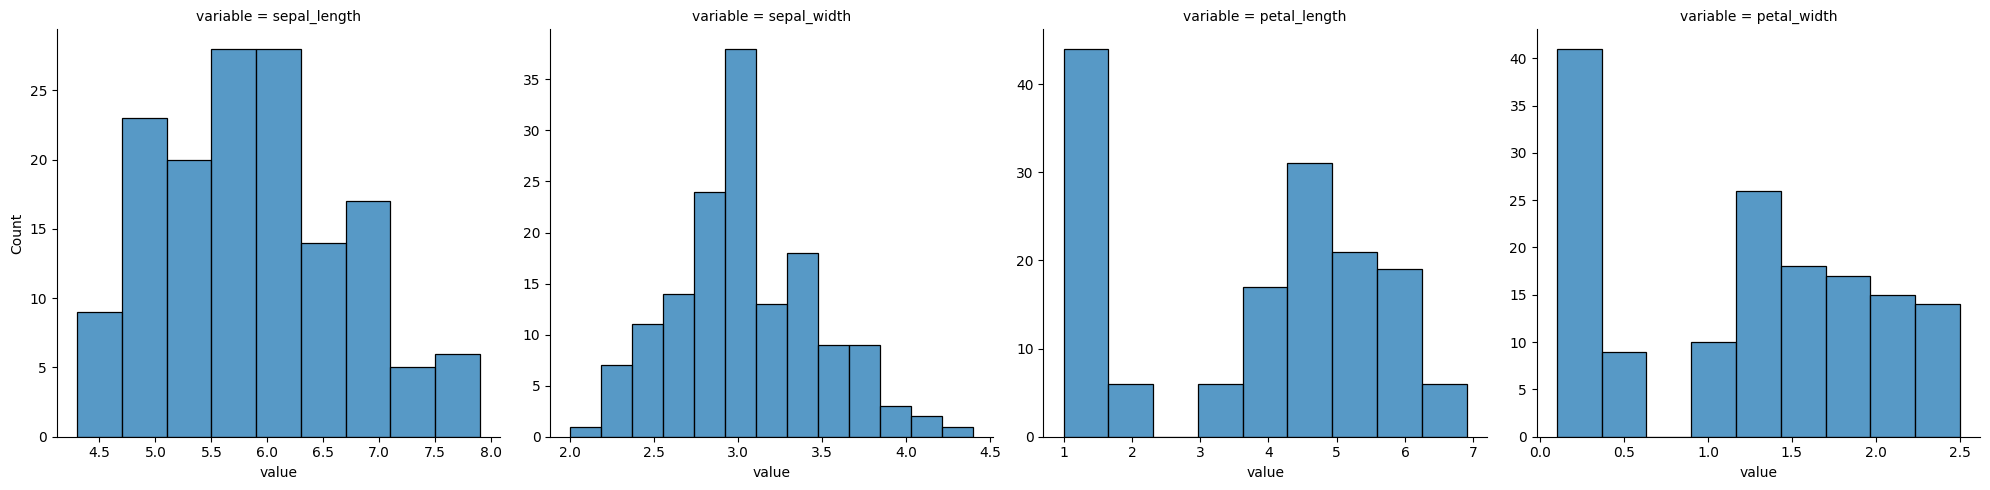

In [34]:
sns.displot(
    data=df_eda_lf,
    x="value",
    col="variable",
    col_wrap=4,
    kind="hist",
    facet_kws={"sharex": False, "sharey": False},
    common_bins=False,
)
plt.show()

### Histogram Plots with Facets - Explore Relationships Between Numerical & Categorical Variables

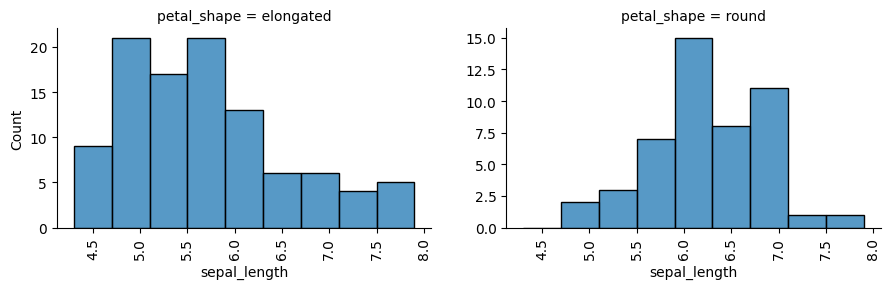

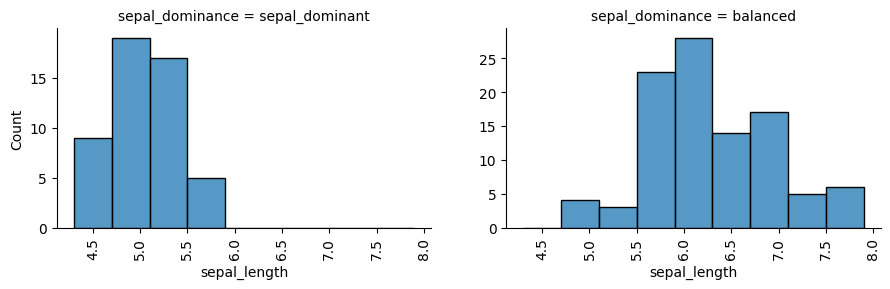

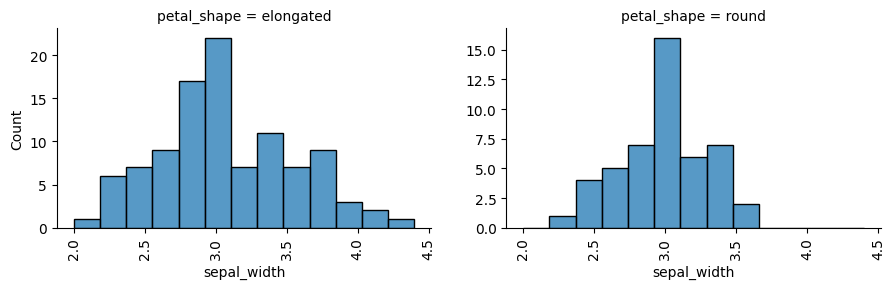

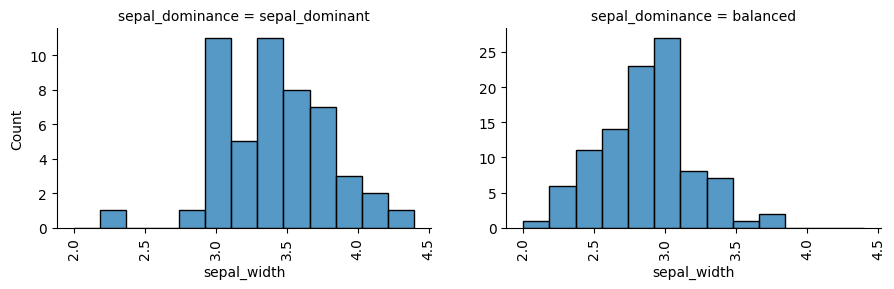

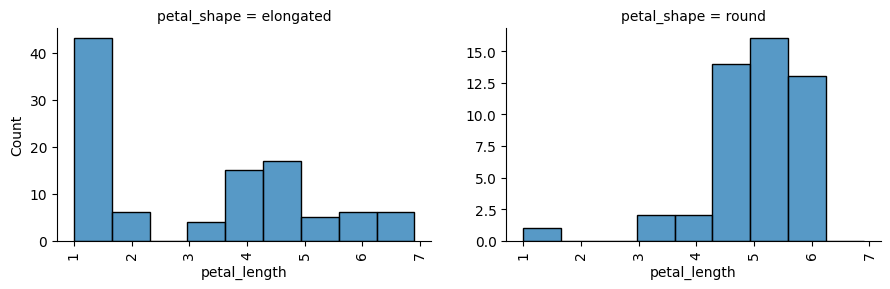

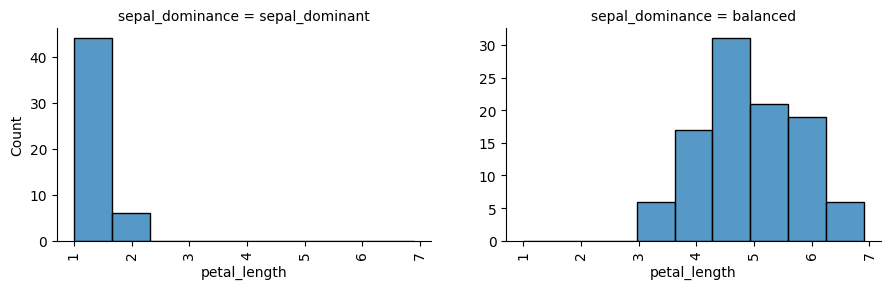

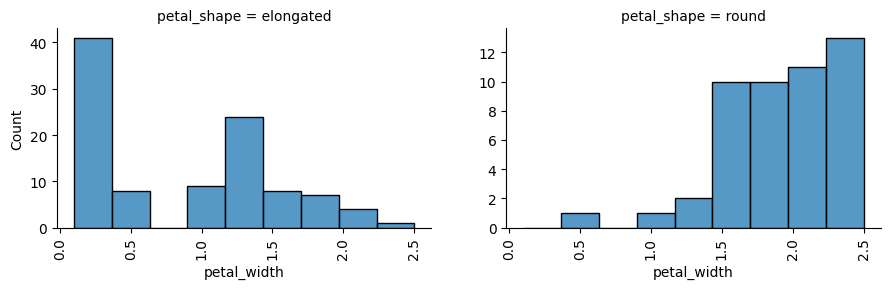

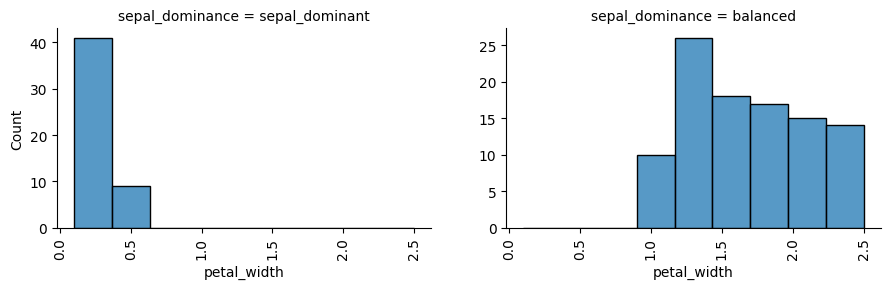

In [35]:
for num_var in CONTINUOUS_FEATURES:
    for cat_var in CATEGORICAL_FEATURES:
        grid = sns.displot(
            data=df_eda,
            x=num_var,
            col=cat_var,
            col_wrap=3,
            kind="hist",
            facet_kws={"sharex": False, "sharey": False},
            height=3,
            aspect=1.5,
        )
        for ax in grid.axes.flatten():
            for label in ax.get_xticklabels():
                label.set_rotation(90)
                label.set_ha("center")
        grid.figure.tight_layout()
        grid.figure.subplots_adjust(hspace=0.4, wspace=0.2)
        plt.show()

### Box Plots — Distribution of Each Numerical Variable by Categorical Variable, Faceted by the Respective Numerical Variable

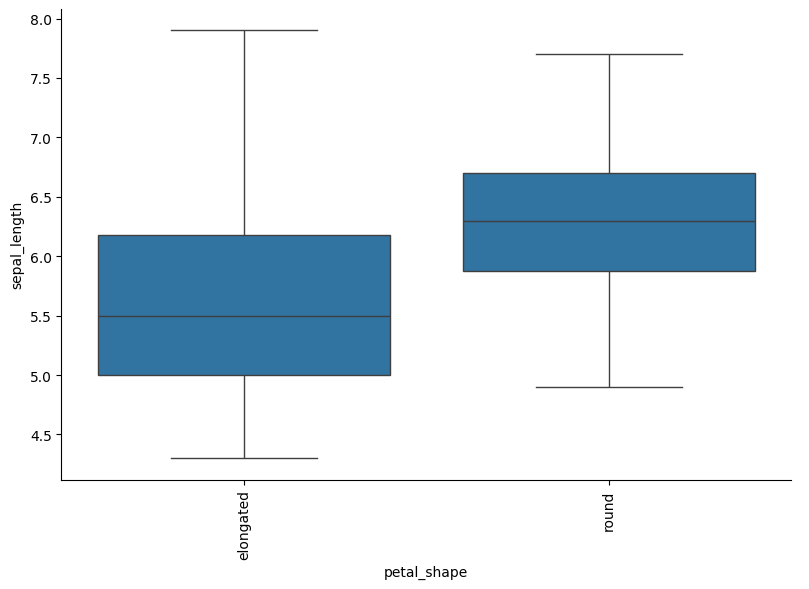

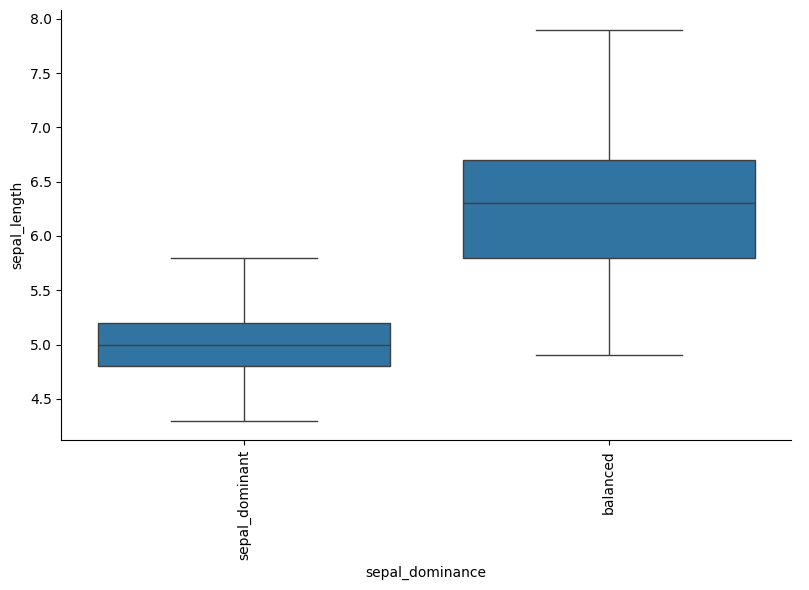

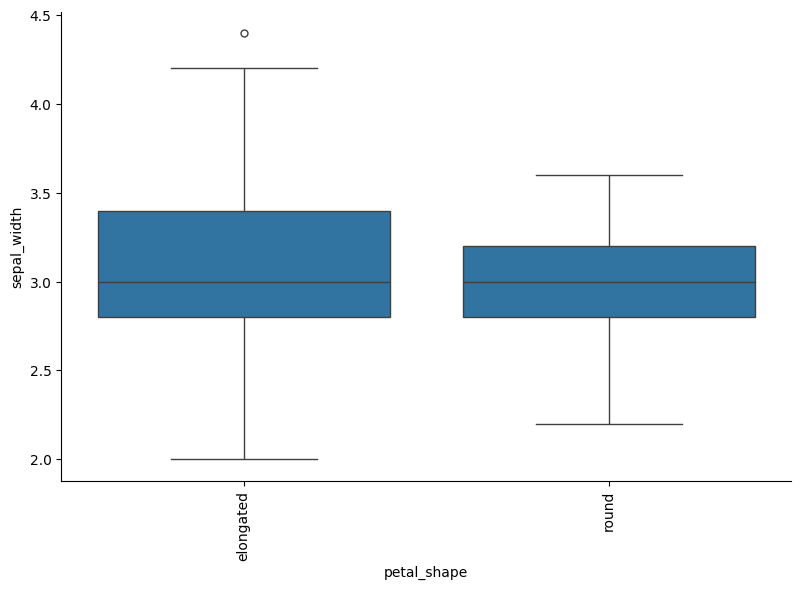

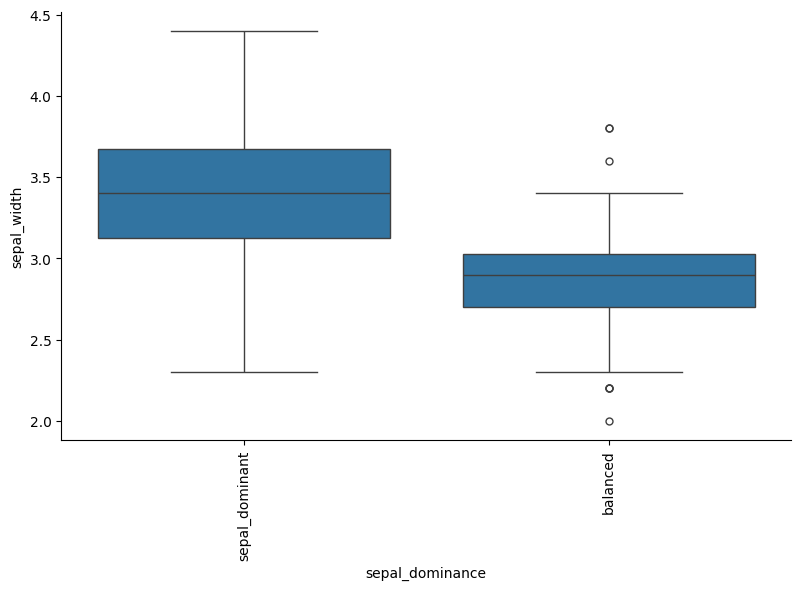

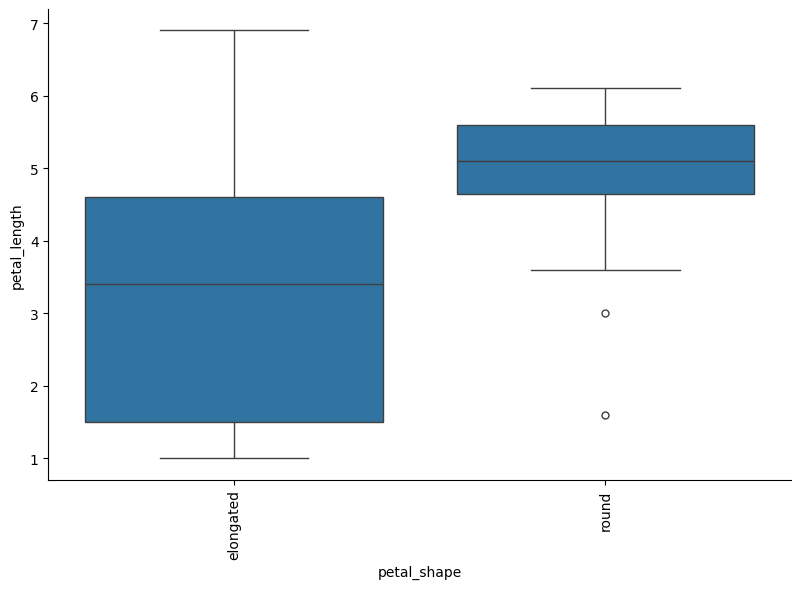

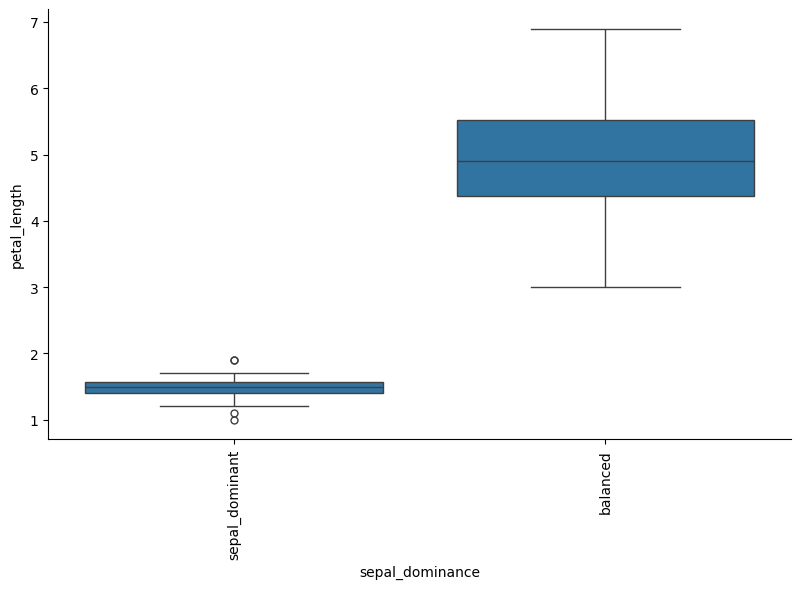

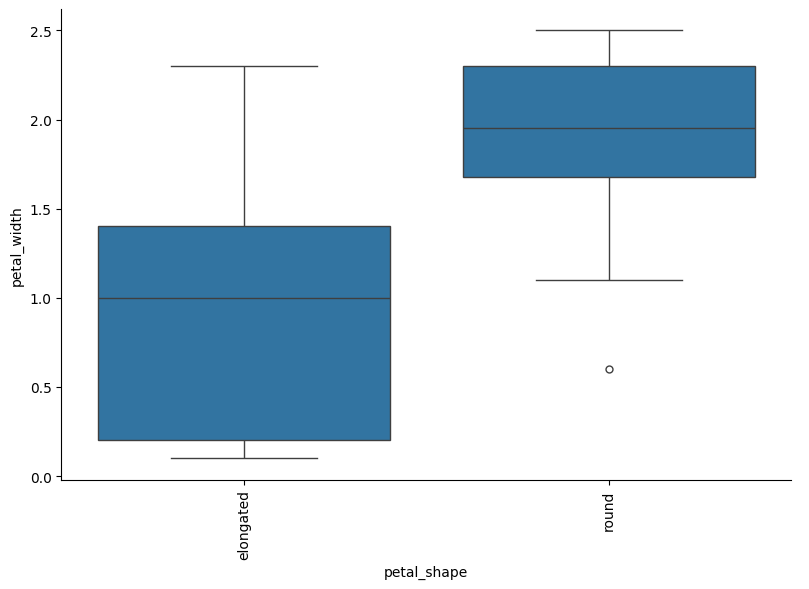

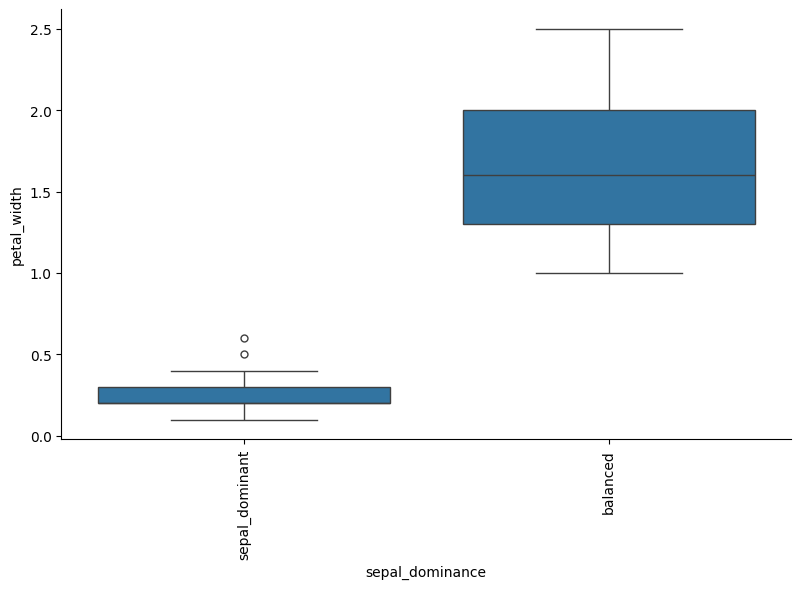

In [36]:
for num_var in CONTINUOUS_FEATURES:
    for cat_var in CATEGORICAL_FEATURES:
        n_categories = df_eda[cat_var].nunique()
        fig_width = max(8, n_categories * 0.6)
        grid = sns.catplot(
            data=df_eda,
            x=cat_var,
            y=num_var,
            kind="box",
            height=6,
            aspect=fig_width / 6,
        )
        for ax in grid.axes.flatten():
            for label in ax.get_xticklabels():
                label.set_rotation(90)
                label.set_ha("center")
        grid.figure.tight_layout()
        grid.figure.subplots_adjust(hspace=0.4, wspace=0.2)
        plt.show()

### Point Plots — Mean and Confidence Interval of Each Numerical Variable by Categorical Variable, Faceted by the Respective Numerical Variable

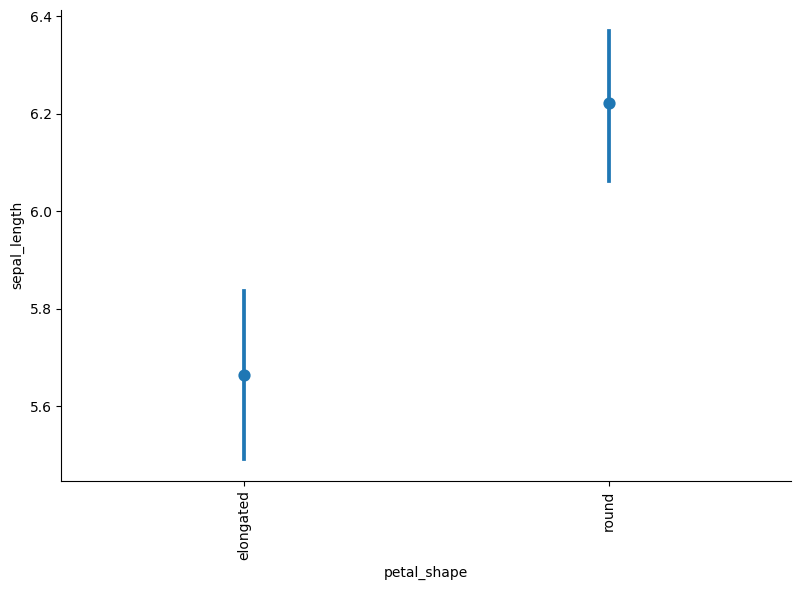

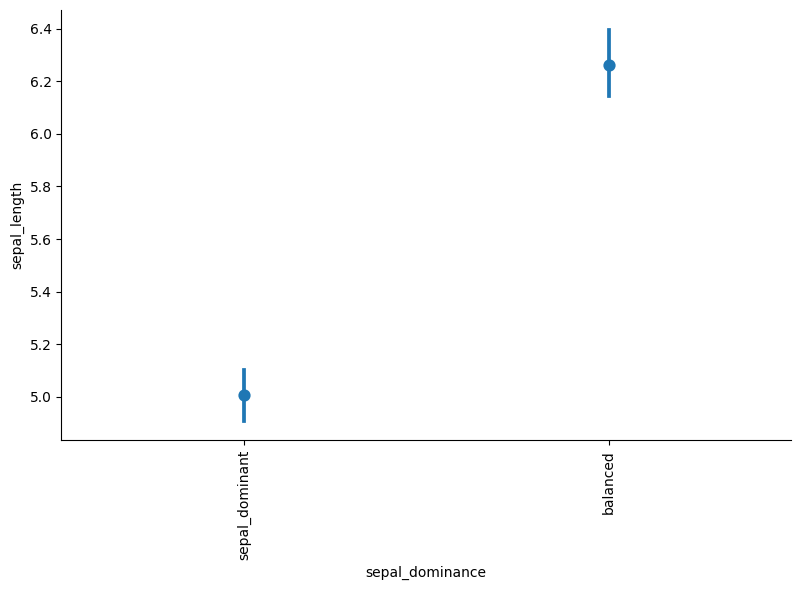

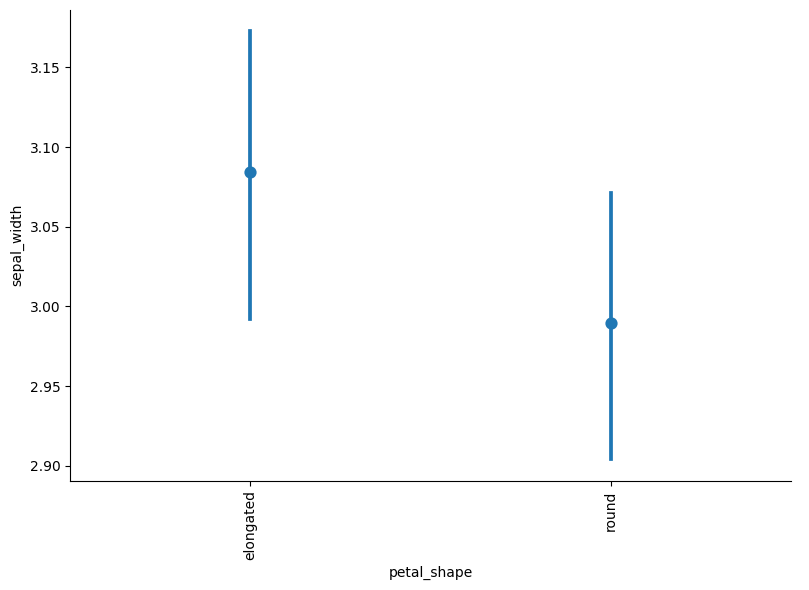

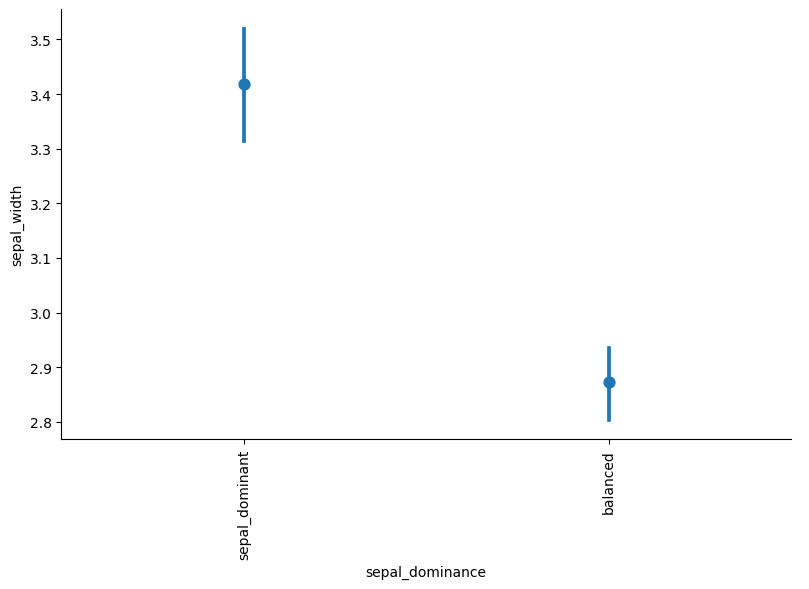

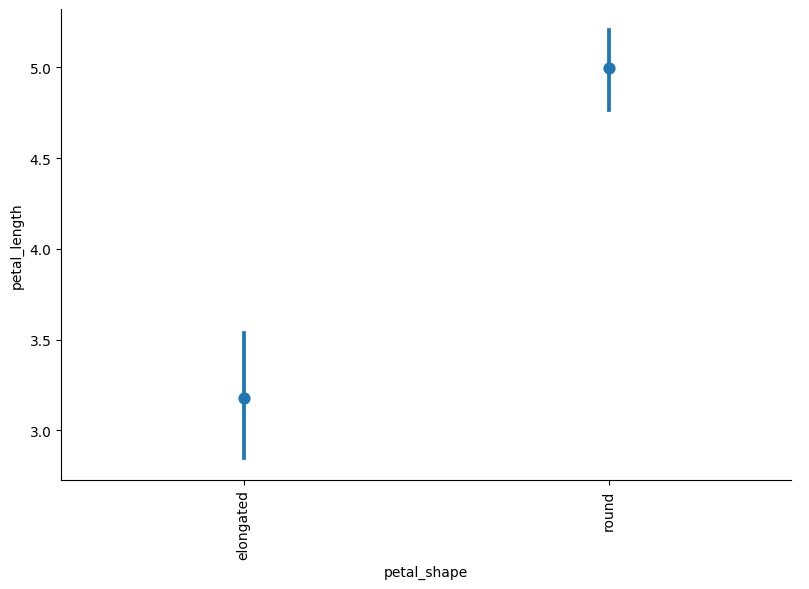

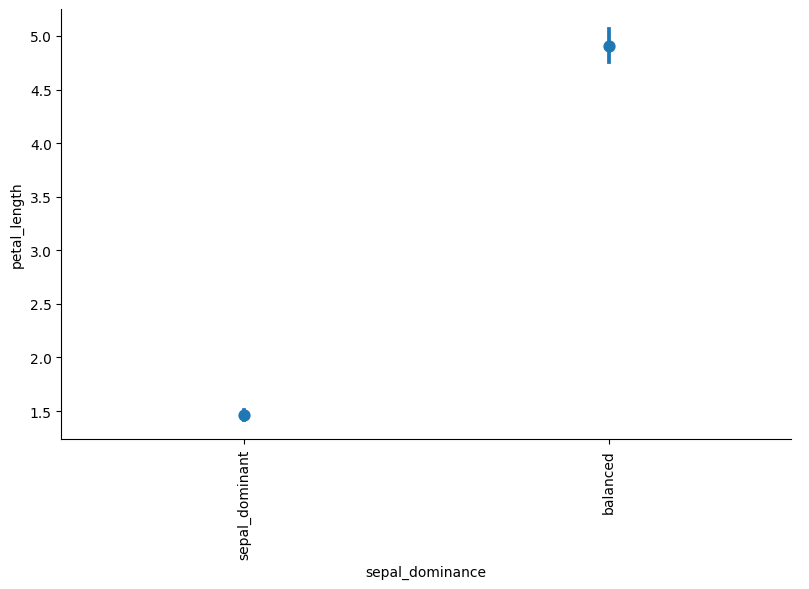

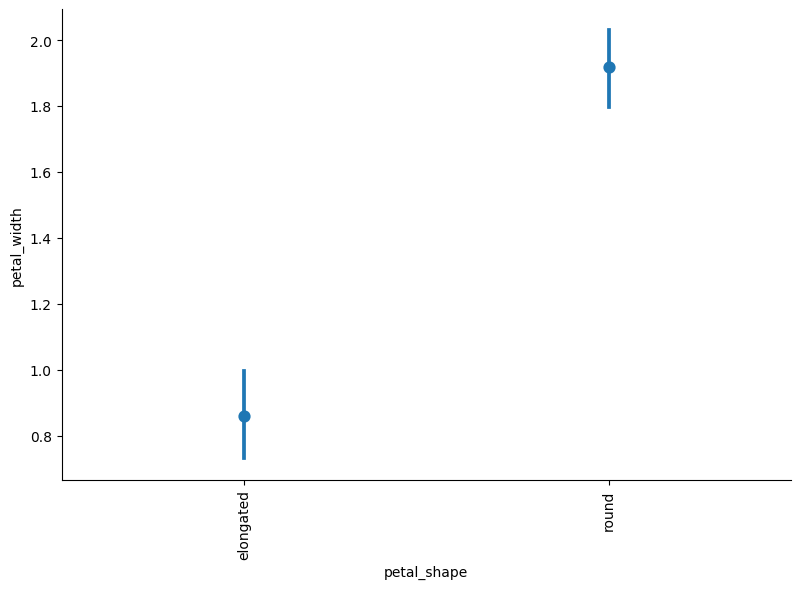

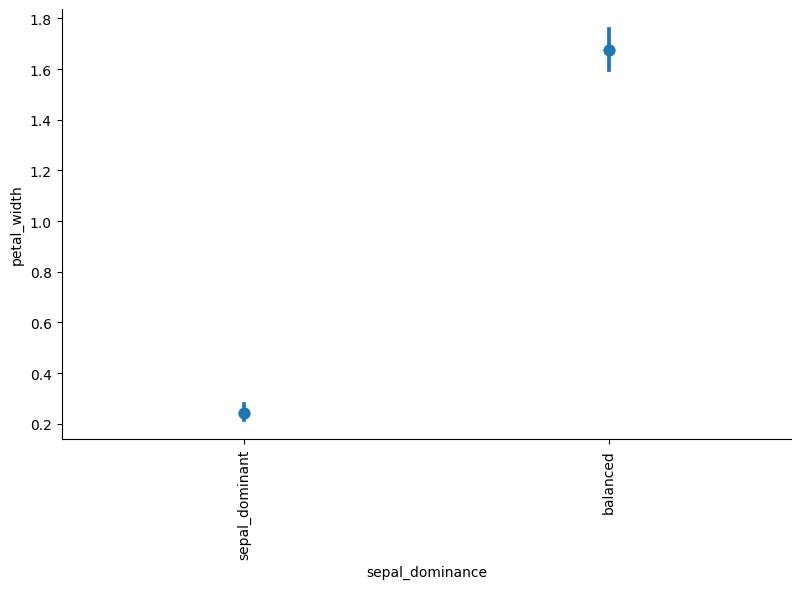

In [37]:
for num_var in CONTINUOUS_FEATURES:
    for cat_var in CATEGORICAL_FEATURES:
        n_categories = df_eda[cat_var].nunique()
        fig_width = max(8, n_categories * 0.6)
        grid = sns.catplot(
            data=df_eda,
            x=cat_var,
            y=num_var,
            kind="point",
            linestyle="none",
            height=6,
            aspect=fig_width / 6,
        )
        for ax in grid.axes.flatten():
            for label in ax.get_xticklabels():
                label.set_rotation(90)
                label.set_ha("center")
        grid.figure.tight_layout()
        grid.figure.subplots_adjust(hspace=0.4, wspace=0.2)
        plt.show()

### Encode Categorical Variables for Correlation, Feature Importance Analysis & Modeling

In [38]:
df_eda.dtypes

sepal_length       float64
sepal_width        float64
petal_length       float64
petal_width        float64
species             object
petal_shape         object
sepal_dominance     object
dtype: object

#### Encode `species` as Integer Labels (Classification)

In [39]:
df_eda["species"].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [40]:
df_eda["species"] = df_eda["species"].map(
    {
        "setosa": 0,
        "versicolor": 1,
        "virginica": 2,
    }
)
df_eda["species"]

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: species, Length: 150, dtype: int64

#### Encode `petal_shape` as Binary Float

In [41]:
df_eda["petal_shape"].value_counts()

petal_shape
elongated    102
round         48
Name: count, dtype: int64

In [42]:
df_eda["petal_shape"] = (
    df_eda["petal_shape"].map({"round": 0, "elongated": 1}).astype(float)
)
df_eda["petal_shape"]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
145    0.0
146    0.0
147    0.0
148    0.0
149    0.0
Name: petal_shape, Length: 150, dtype: float64

#### Encode `sepal_dominance` as Binary Float

In [43]:
df_eda["sepal_dominance"].value_counts()

sepal_dominance
balanced          100
sepal_dominant     50
Name: count, dtype: int64

In [44]:
df_eda["sepal_dominance"] = (
    df_eda["sepal_dominance"].map({"balanced": 0, "sepal_dominant": 1}).astype(float)
)
df_eda["sepal_dominance"]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
145    0.0
146    0.0
147    0.0
148    0.0
149    0.0
Name: sepal_dominance, Length: 150, dtype: float64

### Verify Data Types Match PyTorch Requirements (float for `X`, int for `y`)

In [45]:
df_eda.dtypes

sepal_length       float64
sepal_width        float64
petal_length       float64
petal_width        float64
species              int64
petal_shape        float64
sepal_dominance    float64
dtype: object

### Correlation Plots — Correlation Matrix of All Numerical Variables

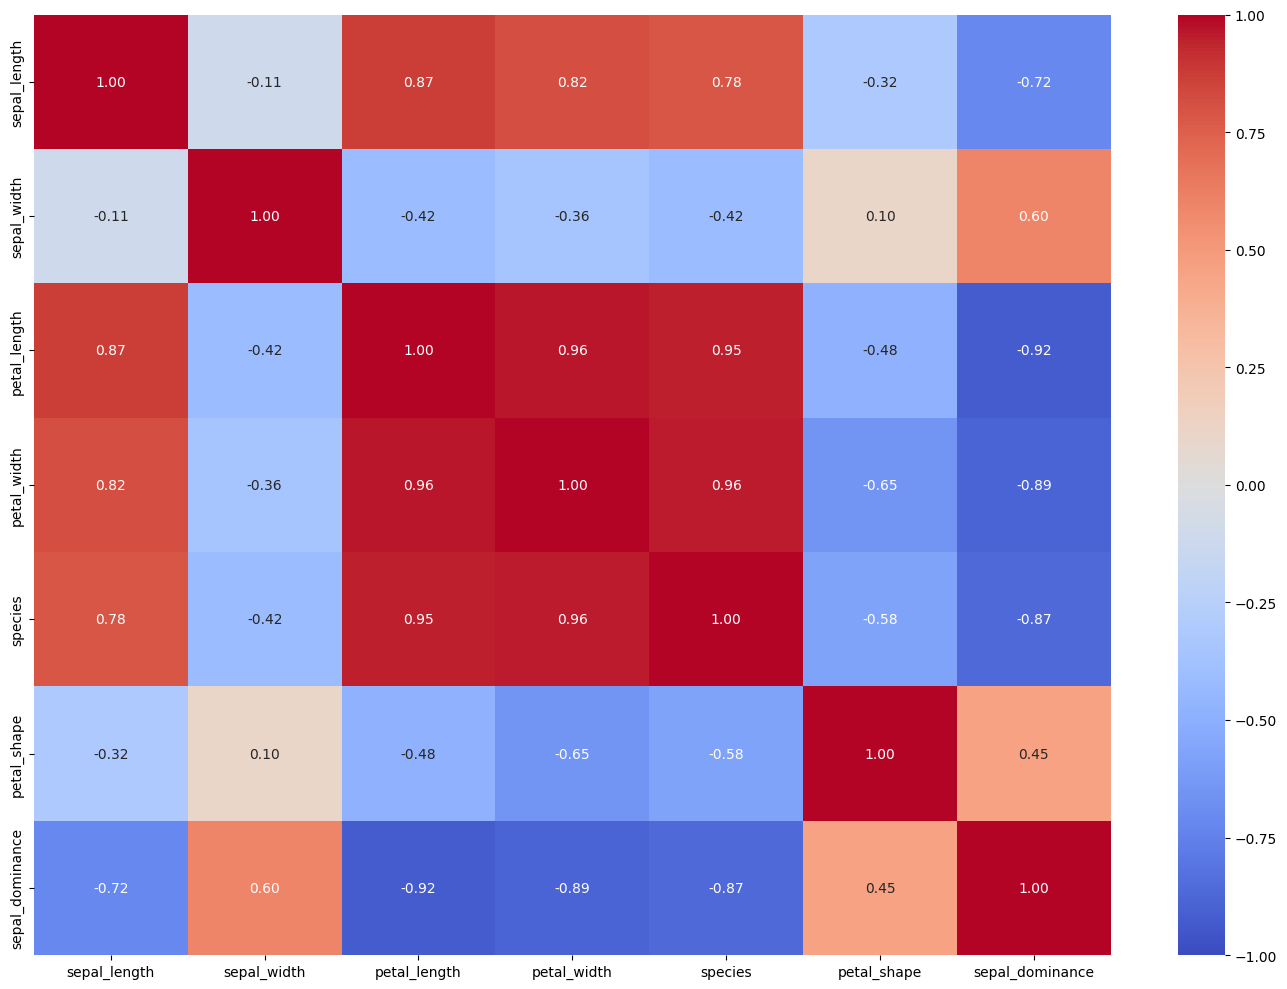

In [46]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(
    data=df_eda.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    cbar=True,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    ax=ax,
)
plt.tight_layout()
plt.show()

### Correlation Plots — Feature Correlation w/ Target Variable

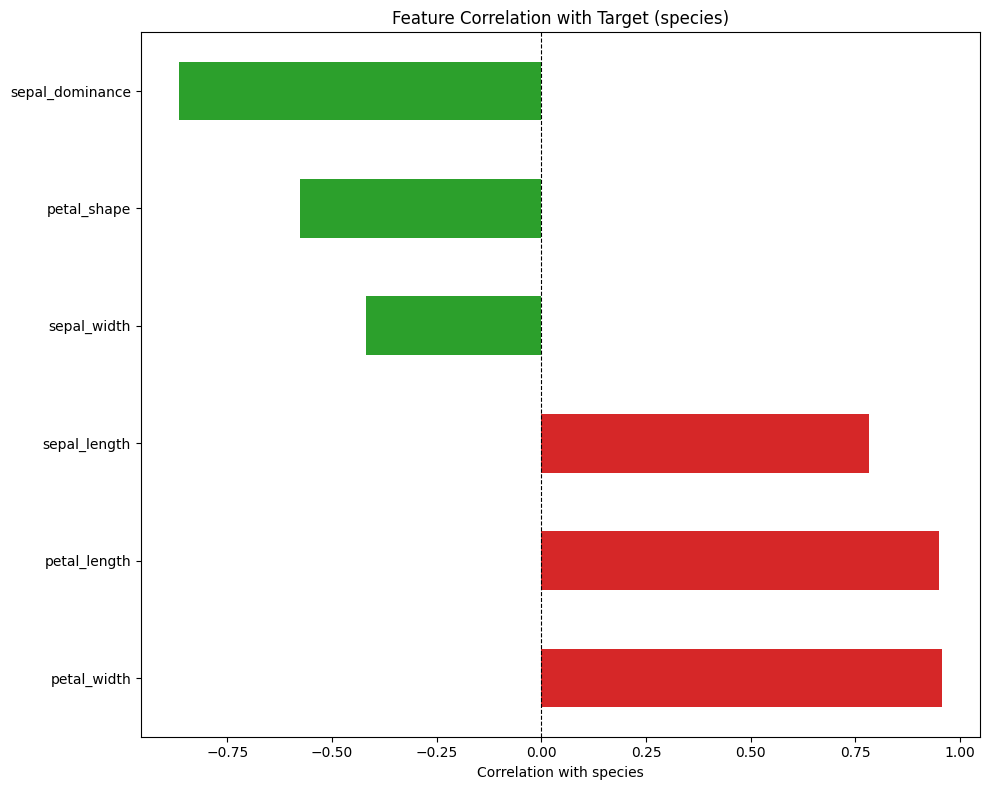

In [47]:
feature_vars = df_eda.columns.drop(TARGET_VAR)
corr_with_target = (
    df_eda[feature_vars].corrwith(df_eda[TARGET_VAR]).sort_values(ascending=False)
)
fig, ax = plt.subplots(figsize=(10, 8))
colors = ["tab:red" if x >= 0 else "tab:green" for x in corr_with_target]
corr_with_target.plot(kind="barh", ax=ax, color=colors)
ax.set_xlabel(f"Correlation with {TARGET_VAR}")
ax.set_title(f"Feature Correlation with Target ({TARGET_VAR})")
ax.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.tight_layout()
plt.show()

### Create `features` Variable for Audit & Modeling

In [48]:
features = [col for col in df_eda.columns if col != TARGET_VAR]
features

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'petal_shape',
 'sepal_dominance']

### Train/Test Split (Pre-Analysis)

Split **before** discriminative score analysis and feature audit to prevent data leakage. Test data must never influence feature selection decisions.

In [49]:
# Stratified split BEFORE analysis to prevent data leakage
df_train, df_test = train_test_split(
    df_eda, test_size=TEST_SIZE, random_state=SEED, stratify=df_eda[TARGET_VAR]
)
print(f"Train: {len(df_train)}, Test: {len(df_test)}")

Train: 105, Test: 45


## Discriminative Score Analysis

The **discriminative score** rates how useful a single feature is for separating two groups (label 0 vs label 1). It combines three normalized signals:

$$S = 0.4\,P + 0.4\,E + 0.2\,M$$

| Symbol | Name | Range | What it captures |
|---|---|---|---|
| $P$ | p-value strength | $[0, 1]$ | $\min\!\bigl(1,\;{-\log_{10}(p)}/{10}\bigr)$ — is the difference real? |
| $E$ | effect size | $[0, 1]$ | Cohen's $d$ (continuous) or Cramér's $V$ (categorical), capped at 1 |
| $M$ | mutual information | $[0, 1]$ | Normalized MI between feature and label |

### How to Interpret Each Value (Good vs Bad)

#### P — p-value strength
| P value | Raw p-value | Interpretation |
|---|---|---|
| < 0.05 | p > 0.3 | **Bad.** The difference could easily be random noise. |
| 0.05 - 0.20 | p ~ 0.01 - 0.1 | **Weak.** Some evidence, but not convincing. |
| 0.20 - 0.50 | p ~ 1e-2 to 1e-5 | **Good.** Strong statistical evidence the groups differ. |
| > 0.50 | p < 1e-5 | **Excellent.** Very strong evidence. |

#### E — effect size (Cohen's d or Cramer's V)
| E value | Interpretation |
|---|---|
| < 0.20 | **Negligible.** Groups overlap almost completely. |
| 0.20 - 0.50 | **Small.** Noticeable difference but lots of overlap. |
| 0.50 - 0.80 | **Medium.** Clear practical difference. |
| > 0.80 | **Large.** Groups are well separated. |

#### M — normalized mutual information
| M value | Interpretation |
|---|---|
| < 0.05 | **Bad.** Feature tells you almost nothing about the label. |
| 0.05 - 0.20 | **Weak.** Slight information gain. |
| 0.20 - 0.50 | **Good.** Feature meaningfully reduces uncertainty about the label. |
| > 0.50 | **Excellent.** Feature strongly predicts the label. |

#### S — final discriminative score
| S value | Interpretation |
|---|---|
| < 0.20 | **Drop it.** The feature is not useful for classification. |
| 0.20 - 0.40 | **Weak.** Might help slightly but do not rely on it alone. |
| 0.40 - 0.60 | **Moderate.** A decent feature worth including. |
| 0.60 - 0.80 | **Strong.** Reliable discriminator — prioritize this feature. |
| > 0.80 | **Excellent.** Top-tier feature with high significance, large effect, and high MI. |

### Continuous Features — Two-Sample t-Test

#### Sample Means

$$\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i$$

#### Sample Variances (Bessel-corrected, ddof=1)

$$s^2 = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2$$

#### Pooled Variance & t-Statistic

**Degrees of freedom:**

$$df = n_0 + n_1 - 2$$

**Pooled variance:**

$$s_p^2 = \frac{(n_0-1)\,s_0^2 + (n_1-1)\,s_1^2}{df}$$

**t-statistic:**

$$t = \frac{\bar{x}_1 - \bar{x}_0}{s_p\,\sqrt{\dfrac{1}{n_0} + \dfrac{1}{n_1}}}$$

#### Cohen's d → Component $E$

$$d = \frac{\bar{x}_1 - \bar{x}_0}{s_p}$$

$$E = \min(1,\;|d|)$$

### Categorical Features — Chi-Square Test

#### Contingency Table & Chi-Square Statistic

**Expected count:**

$$E_{ij} = \frac{(\text{row total}_i)(\text{col total}_j)}{n}$$

**Degrees of freedom:**

$$df = (r-1)(c-1)$$

**Chi-square statistic:**

$$\chi^2 = \sum_{i,j}\frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

#### Cramér's V → Component $E$

$$V = \sqrt{\frac{\chi^2}{n\,(\min(r,c) - 1)}}$$

$$E = \min(1,\;V)$$

### NMI → Component $M$

**Mutual Information:**

$$I(X;Y) = \sum_{x,y} p(x,y)\,\ln\!\frac{p(x,y)}{p(x)\,p(y)}$$

**Entropy:**

$$H(X) = -\sum_x p(x)\,\ln p(x)$$

**Normalized Mutual Information:**

$$\text{NMI} = \frac{I}{\sqrt{H(X) \cdot H(Y)}}$$

$$M = \text{NMI}$$

#### P Component & Final Score

$$P = \min\!\left(1,\;\frac{-\log_{10}(p)}{10}\right)$$

$$S = 0.4\,P + 0.4\,E + 0.2\,M$$

### Reusable Function: `compute_discriminative_score()`

Private helpers (prefixed `_`) are defined above the main function, in the exact order they are called.

In [50]:
def _infer_feature_type(values):
    """
    Infer whether a pandas Series is continuous or categorical.

    Parameters:
        values (pd.Series): Feature column to evaluate.

    Returns:
        str: 'continuous' if numeric dtype, otherwise 'categorical'.
    """
    return "continuous" if pd.api.types.is_numeric_dtype(values) else "categorical"


def _continuous_stats(g0, g1, labels, values):
    """
    Compute p-value, effect size (Cohen's d), and NMI for a continuous feature.

    Parameters:
        g0 (np.ndarray): Feature values for label-0 samples.
        g1 (np.ndarray): Feature values for label-1 samples.
        labels (pd.Series): Full label column.
        values (pd.Series): Full feature column (used for median-split binning).

    Returns:
        tuple: (p_value, cohens_d, nmi).
    """
    n0, n1 = len(g0), len(g1)
    sp2 = ((n0 - 1) * g0.var(ddof=1) + (n1 - 1) * g1.var(ddof=1)) / (n0 + n1 - 2)
    sp = np.sqrt(sp2)
    _, p = stats.ttest_ind(g0, g1, equal_var=True)
    d = abs(g1.mean() - g0.mean()) / sp if sp > 0 else 0.0
    binned = (values > values.median()).astype(int)
    nmi = normalized_mutual_info_score(labels, binned)
    return p, d, nmi


def _categorical_stats(labels, values, n):
    """
    Compute p-value, effect size (Cramer's V), and NMI for a categorical feature.

    Parameters:
        labels (pd.Series): Binary label column.
        values (pd.Series): Categorical feature column.
        n (int): Total number of samples.

    Returns:
        tuple: (p_value, cramers_v, nmi).
    """
    ct = pd.crosstab(labels, values)
    chi2, p, _, _ = stats.chi2_contingency(ct, correction=False)
    k = min(ct.shape)
    v = np.sqrt(chi2 / (n * max(k - 1, 1)))
    nmi = normalized_mutual_info_score(labels, values)
    return p, v, nmi


def _compute_raw_stats(feature_type, labels, values, n):
    """
    Dispatch to the correct statistical test based on feature type.

    Parameters:
        feature_type (str): 'continuous' or 'categorical'.
        labels (pd.Series): Binary label column.
        values (pd.Series): Feature column.
        n (int): Total number of samples.

    Returns:
        tuple: (p_value, effect_size, nmi).
    """
    if feature_type == "continuous":
        g0 = values[labels == 0].dropna().values
        g1 = values[labels == 1].dropna().values
        return _continuous_stats(g0, g1, labels, values)
    return _categorical_stats(labels, values, n)


def _score_components(p_value, effect_size, nmi):
    """
    Normalize raw statistics into the P, E, M components and compute S.

    Parameters:
        p_value (float): Raw p-value from the statistical test.
        effect_size (float): Raw effect size (Cohen's d or Cramer's V).
        nmi (float): Normalized mutual information.

    Returns:
        dict: Keys: p_value, effect_size, nmi, P, E, M, S.
    """
    P = min(1.0, -np.log10(max(p_value, 1e-300)) / 10)
    E = min(1.0, effect_size)
    M = nmi
    S = 0.4 * P + 0.4 * E + 0.2 * M
    return {
        "p_value": p_value,
        "effect_size": effect_size,
        "nmi": nmi,
        "P": P,
        "E": E,
        "M": M,
        "S": S,
    }


def compute_discriminative_score(df, feature_col, label_col, feature_type="auto"):
    """
    Compute the discriminative score for a single feature.

    Parameters:
        df (pd.DataFrame): Input dataframe containing feature and label columns.
        feature_col (str): Name of the feature column to evaluate.
        label_col (str): Name of the binary label column (0 or 1).
        feature_type (str): 'continuous', 'categorical', or 'auto' (default: 'auto').

    Returns:
        dict: Keys: p_value, effect_size, nmi, P, E, M, S.
    """
    labels, values = df[label_col], df[feature_col]
    if feature_type == "auto":
        feature_type = _infer_feature_type(values)
    p, effect, nmi = _compute_raw_stats(feature_type, labels, values, len(df))
    return _score_components(p, effect, nmi)

### Apply Discriminative Score to Iris Features (One-vs-Rest)

Since Iris has 3 classes, we compute discriminative scores using a **one-vs-rest** (OVR) approach: for each species, we create a binary label (1 = target species, 0 = all others) and evaluate every feature.

In [51]:
# Define feature types for discriminative score computation
feature_types = {col: "continuous" for col in CONTINUOUS_FEATURES}
for cat in CATEGORICAL_FEATURES:
    feature_types[cat] = "categorical"

# Compute discriminative scores for each feature vs each class (OVR)
disc_results = []
for class_idx, class_name in SPECIES_MAP.items():
    df_disc = df_train.copy()
    df_disc["binary_label"] = (df_disc[TARGET_VAR] == class_idx).astype(int)
    for feat in features:
        score = compute_discriminative_score(
            df_disc, feat, "binary_label", feature_type=feature_types[feat]
        )
        disc_results.append({"Feature": feat, "Class": class_name, **score})
disc_df = pd.DataFrame(disc_results)
disc_df

,Feature,Class,p_value,effect_size,nmi,P,E,M,S
0,sepal_length,setosa,1.288405e-18,2.234062,0.413999,1.000000,1.000000,0.413999,0.882800
1,sepal_width,setosa,3.478401e-10,1.437961,0.197960,0.945862,1.000000,0.197960,0.817937
2,petal_length,setosa,1.611085e-42,4.780438,0.455829,1.000000,1.000000,0.455829,0.891166
3,petal_width,setosa,1.472239e-35,3.946378,0.427411,1.000000,1.000000,0.427411,0.885482
4,petal_shape,setosa,2.736120e-06,0.457667,0.239752,0.556286,0.457667,0.239752,0.453532
5,sepal_dominance,setosa,1.221358e-24,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,sepal_length,versicolor,5.301533e-01,0.130402,0.004954,0.027560,0.130402,0.004954,0.064176
7,sepal_width,versicolor,5.931626e-08,1.210525,0.154467,0.722683,1.000000,0.154467,0.719966
8,petal_length,versicolor,6.628994e-02,0.384261,0.001230,0.117855,0.384261,0.001230,0.201092
9,petal_width,versicolor,3.365922e-01,0.199862,0.006762,0.047290,0.199862,0.006762,0.100213


### Discriminative Score Visualization — Average Feature Importance

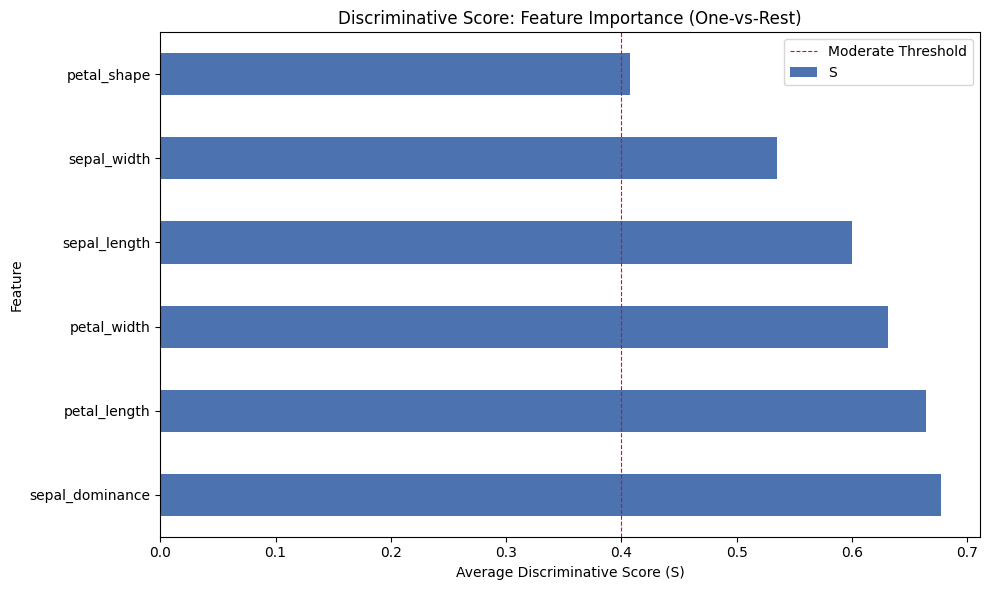

In [52]:
# Average discriminative score across all OVR comparisons per feature
avg_scores = disc_df.groupby("Feature")["S"].mean().sort_values(ascending=False)

# Plot discriminative scores
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["#4C72B0" if s >= 0.4 else "#DD8452" for s in avg_scores]
avg_scores.plot(kind="barh", ax=ax, color=colors)
ax.set_xlabel("Average Discriminative Score (S)")
ax.set_title("Discriminative Score: Feature Importance (One-vs-Rest)")
ax.axvline(
    x=0.4, color="red", linestyle="--", linewidth=0.8, label="Moderate Threshold"
)
ax.legend()
plt.tight_layout()
plt.show()

### Discriminative Score Visualization — Component Breakdown by Class

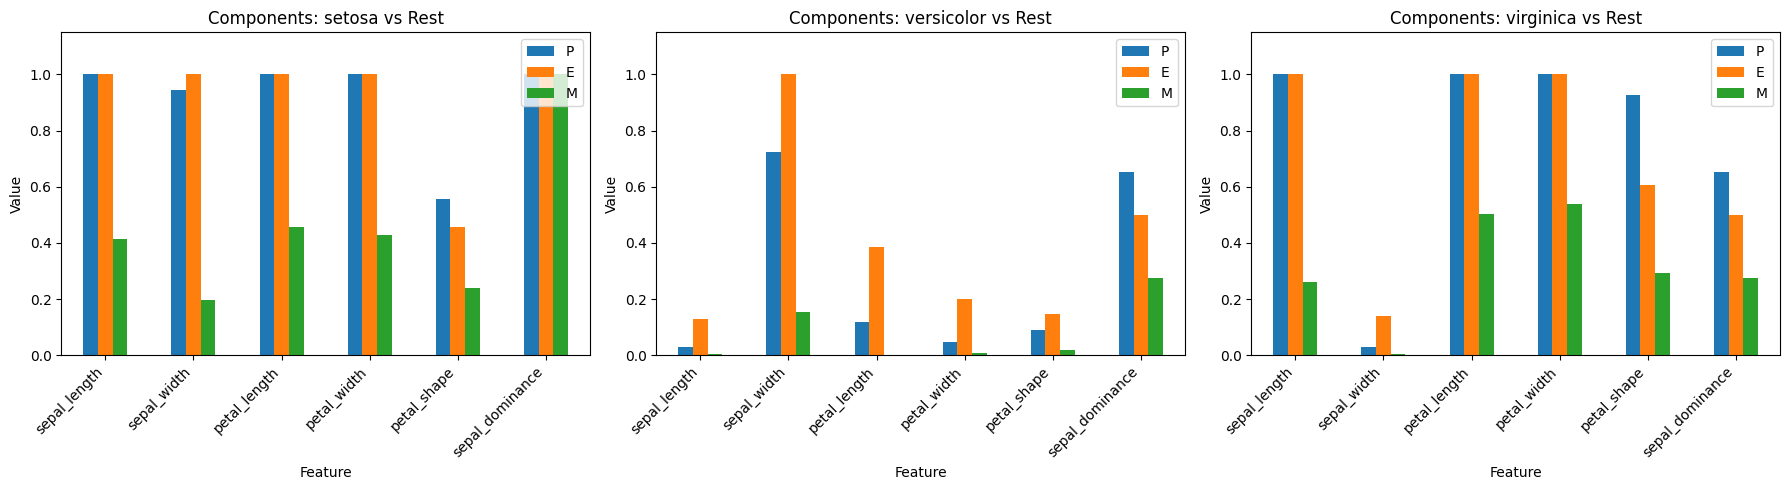

In [53]:
# Component breakdown: P, E, M side by side for each class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, class_name in enumerate(["setosa", "versicolor", "virginica"]):
    class_data = disc_df[disc_df["Class"] == class_name].set_index("Feature")
    class_data[["P", "E", "M"]].plot(kind="bar", ax=axes[idx], ylim=(0, 1.15))
    axes[idx].set_title(f"Components: {class_name} vs Rest")
    axes[idx].set_ylabel("Value")
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha="right")
    axes[idx].legend(loc="upper right")
plt.tight_layout()
plt.show()

## Feature Selection Audit: Discriminative Score & Correlation

In [54]:
def audit_reason(s):
    """
    Return a human-readable reason string based on discriminative score.

    Parameters:
        s (float): Average discriminative score.

    Returns:
        str: Interpretation of the score.
    """
    if s >= 0.8:
        return "Excellent — top-tier discriminator"
    if s >= 0.6:
        return "Strong — reliable discriminator"
    if s >= 0.4:
        return "Moderate — decent feature"
    if s >= 0.2:
        return "Weak — marginal value"
    return "Drop — not useful for classification"

In [55]:
all_corrs = df_train[features].corrwith(df_train[TARGET_VAR])
results = []
for col in features:
    s = avg_scores[col]
    corr = all_corrs[col]
    recommendation = "\u2705 KEEP" if s >= 0.4 else "\u274c DROP"
    reason = audit_reason(s)
    results.append(
        {
            "Feature": col,
            "Avg_S": round(s, 4),
            "Correlation": round(corr, 4),
            "Recommendation": recommendation,
            "Reason": reason,
        }
    )
audit_df = (
    pd.DataFrame(results).sort_values("Avg_S", ascending=False).reset_index(drop=True)
)
audit_df

,Feature,Avg_S,Correlation,Recommendation,Reason
0,sepal_dominance,0.6771,-0.8660,✅ KEEP,Strong — reliable discriminator
1,petal_length,0.6643,0.9532,✅ KEEP,Strong — reliable discriminator
2,petal_width,0.6311,0.9646,✅ KEEP,Strong — reliable discriminator
3,sepal_length,0.5997,0.8054,✅ KEEP,Moderate — decent feature
4,sepal_width,0.5352,-0.3639,✅ KEEP,Moderate — decent feature
5,petal_shape,0.4076,-0.6137,✅ KEEP,Moderate — decent feature


## Preprocessing

### Create `df_preprocessed` Dataset

In [56]:
df_preprocessed = df_eda.copy()
df_preprocessed.shape

(150, 7)

### Drop Low-Correlation Features

#### Based on Recommendations, Drop Features w/ Low-Correlation

In [57]:
# df_preprocessed.drop(columns=[
#     "",
# ], inplace=True)
# df_preprocessed

### Save `df_preprocessed` Processed Dataset

In [58]:
df_preprocessed.to_csv("iris_dataset_preprocessed.csv", index=False)

### Load `df_preprocessed` Processed Dataset

In [59]:
df_preprocessed = pd.read_csv("iris_dataset_preprocessed.csv")
df_preprocessed

,sepal_length,sepal_width,petal_length,petal_width,species,petal_shape,sepal_dominance
0,5.1,3.5,1.4,0.2,0,1.0,1.0
1,4.9,3.0,1.4,0.2,0,1.0,1.0
2,4.7,3.2,1.3,0.2,0,1.0,1.0
3,4.6,3.1,1.5,0.2,0,1.0,1.0
4,5.0,3.6,1.4,0.2,0,1.0,1.0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,0.0,0.0
146,6.3,2.5,5.0,1.9,2,0.0,0.0
147,6.5,3.0,5.2,2.0,2,0.0,0.0
148,6.2,3.4,5.4,2.3,2,0.0,0.0


## Reusable ML Pipeline

### Model Architecture

In [60]:
class IrisMLP(nn.Module):
    """A feedforward neural network with two hidden layers and optional dropout."""

    def __init__(self, in_features, h1=8, h2=8, out_features=3, dropout=0.0):
        """
        Initialize the neural network layers.

        Parameters:
            in_features (int): Number of input features.
            h1 (int): Neurons in hidden layer 1.
            h2 (int): Neurons in hidden layer 2.
            out_features (int): Number of output classes.
            dropout (float): Dropout rate.
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Define the forward pass.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output logits.
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.out(x)

### Dataset Class

In [61]:
class NumpyDataset(torch.utils.data.Dataset):
    """Memory-efficient dataset converting numpy arrays to tensors on demand."""

    def __init__(self, X, y, device):
        """
        Initialize with numpy arrays.

        Parameters:
            X (np.ndarray): Feature array.
            y (np.ndarray): Label array.
            device (torch.device): Target device.
        """
        self.X = X
        self.y = y
        self.device = device

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.X)

    def __getitem__(self, idx):
        """
        Return a single sample as tensors on the specified device.

        Parameters:
            idx (int): Sample index.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Feature and label tensors.
        """
        X_tensor = torch.tensor(self.X[idx]).float().to(self.device)
        y_tensor = torch.tensor(self.y[idx]).long().to(self.device)
        return X_tensor, y_tensor

### Data Preparation Functions

In [62]:
def _extract_arrays(df, feature_cols, target_col):
    """
    Extract feature and target arrays from a DataFrame.

    Parameters:
        df (pd.DataFrame): Source dataframe.
        feature_cols (list): Feature column names.
        target_col (str): Target column name.

    Returns:
        tuple: (X, y) as numpy arrays.
    """
    X = df[feature_cols].values.astype("float32")
    y = df[target_col].values.astype("int64")
    return X, y


def _fit_scaler(X_train, feature_cols):
    """
    Fit StandardScaler on training features.

    Parameters:
        X_train (np.ndarray): Training feature array.
        feature_cols (list): Feature column names.

    Returns:
        tuple: (scaled_DataFrame, fitted_scaler).
    """
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols)
    return X_scaled, scaler


def _scale_array(X, scaler, feature_cols):
    """
    Transform a feature array with a fitted scaler.

    Parameters:
        X (np.ndarray): Feature array to transform.
        scaler (StandardScaler): Fitted scaler.
        feature_cols (list): Feature column names.

    Returns:
        pd.DataFrame: Scaled features.
    """
    return pd.DataFrame(scaler.transform(X), columns=feature_cols)


def _split_indices(n, size, seed, stratify):
    """
    Return stratified train/validation index arrays.

    Parameters:
        n (int): Total number of samples.
        size (float): Fraction for the validation set.
        seed (int): Random seed.
        stratify (np.ndarray): Labels for stratification.

    Returns:
        tuple: (train_indices, val_indices).
    """
    return train_test_split(
        np.arange(n), test_size=size, random_state=seed, stratify=stratify
    )


def prepare_data(df_train, df_test, feature_cols, target_col, val_size, seed):
    """
    Sub-split train into train/val, scale all three sets, return arrays + scaler.

    Parameters:
        df_train (pd.DataFrame): Training dataframe (from early split).
        df_test (pd.DataFrame): Test dataframe (from early split).
        feature_cols (list): Feature column names.
        target_col (str): Target column name.
        val_size (float): Fraction of training data for validation.
        seed (int): Random seed.

    Returns:
        tuple: (X_tr, X_val, X_te, y_tr, y_val, y_te, scaler).
    """
    X_all, y_all = _extract_arrays(df_train, feature_cols, target_col)
    X_te_raw, y_te = _extract_arrays(df_test, feature_cols, target_col)
    tr_idx, val_idx = _split_indices(len(X_all), val_size, seed, y_all)
    X_tr, scaler = _fit_scaler(X_all[tr_idx], feature_cols)
    X_val = _scale_array(X_all[val_idx], scaler, feature_cols)
    X_te = _scale_array(X_te_raw, scaler, feature_cols)
    return X_tr, X_val, X_te, y_all[tr_idx], y_all[val_idx], y_te, scaler


def _compute_class_weights(y_train, device):
    """
    Compute inverse-frequency class weights for imbalanced datasets.

    Parameters:
        y_train (np.ndarray): Training labels.
        device (torch.device): Target device for the weight tensor.

    Returns:
        torch.Tensor: Class weight tensor (balanced datasets get ~equal weights).
    """
    counts = np.bincount(y_train)
    weights = len(y_train) / (len(counts) * counts)
    return torch.tensor(weights, dtype=torch.float32).to(device)


def _make_loader(X, y, device, batch_size, shuffle):
    """
    Create a DataLoader from a feature DataFrame and label array.

    Parameters:
        X (pd.DataFrame): Scaled feature DataFrame.
        y (np.ndarray): Label array.
        device (torch.device): Target device.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle.

    Returns:
        DataLoader: Configured data loader.
    """
    return DataLoader(
        NumpyDataset(X.values, y, device), batch_size=batch_size, shuffle=shuffle
    )


def create_loaders(X_tr, X_val, X_te, y_tr, y_val, y_te, device, batch_size):
    """
    Create train, validation, and test DataLoaders.

    Parameters:
        X_tr (pd.DataFrame): Scaled training features.
        X_val (pd.DataFrame): Scaled validation features.
        X_te (pd.DataFrame): Scaled test features.
        y_tr (np.ndarray): Training labels.
        y_val (np.ndarray): Validation labels.
        y_te (np.ndarray): Test labels.
        device (torch.device): Target device.
        batch_size (int): Batch size.

    Returns:
        tuple: (train_loader, val_loader, test_loader).
    """
    train_ldr = _make_loader(X_tr, y_tr, device, batch_size, shuffle=True)
    val_ldr = _make_loader(X_val, y_val, device, batch_size, shuffle=False)
    test_ldr = _make_loader(X_te, y_te, device, batch_size, shuffle=False)
    return train_ldr, val_ldr, test_ldr

### Training Functions

In [63]:
def _train_batch(model, X_batch, y_batch, criterion, optimizer):
    """
    Process one training batch and return batch loss.

    Parameters:
        model (nn.Module): Model being trained.
        X_batch (torch.Tensor): Input batch.
        y_batch (torch.Tensor): Label batch.
        criterion: Loss function.
        optimizer: Optimizer.

    Returns:
        float: Batch loss value.
    """
    optimizer.zero_grad()
    loss = criterion(model(X_batch), y_batch)
    loss.backward()
    optimizer.step()
    return loss.item()


def _run_train_epoch(model, loader, criterion, optimizer):
    """
    Run one full training epoch and return average loss.

    Parameters:
        model (nn.Module): Model being trained.
        loader (DataLoader): Training data loader.
        criterion: Loss function.
        optimizer: Optimizer.

    Returns:
        float: Average training loss for the epoch.
    """
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in loader:
        total_loss += _train_batch(model, X_batch, y_batch, criterion, optimizer)
    return total_loss / len(loader)


def _run_val_epoch(model, loader, criterion):
    """
    Run one full validation epoch and return average loss.

    Parameters:
        model (nn.Module): Model being evaluated.
        loader (DataLoader): Validation data loader.
        criterion: Loss function.

    Returns:
        float: Average validation loss for the epoch.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            total_loss += criterion(model(X_batch), y_batch).item()
    return total_loss / len(loader)


def _save_if_improved(model, val_loss, best_val_loss, path, counter):
    """
    Save model if val loss improved; return (best_loss, patience_counter).

    Parameters:
        model (nn.Module): Model to potentially save.
        val_loss (float): Current validation loss.
        best_val_loss (float): Best validation loss so far.
        path (str): File path for saving weights.
        counter (int): Current patience counter.

    Returns:
        tuple: (updated_best_loss, updated_patience_counter).
    """
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), path)
        return val_loss, 0
    return best_val_loss, counter + 1


def _check_early_stop(counter, patience, epoch):
    """
    Print message and return True if patience is exhausted.

    Parameters:
        counter (int): Epochs without improvement.
        patience (int): Maximum allowed patience.
        epoch (int): Current epoch number.

    Returns:
        bool: True if training should stop.
    """
    if counter >= patience:
        print(f"Early stopping at epoch {epoch} (patience={patience})")
        return True
    return False


def _log_progress(epoch, epochs, train_loss, val_loss, interval):
    """
    Print epoch progress at specified intervals.

    Parameters:
        epoch (int): Current epoch number.
        epochs (int): Total number of epochs.
        train_loss (float): Training loss for this epoch.
        val_loss (float): Validation loss for this epoch.
        interval (int): Logging interval.
    """
    if epoch % interval == 0:
        print(f"Epoch {epoch}/{epochs} - Train: {train_loss:.4f} - Val: {val_loss:.4f}")


def train_model(model, train_loader, val_loader, criterion, optimizer, config):
    """
    Full training loop with validation, checkpointing, early stopping, and logging.

    Parameters:
        model (nn.Module): Model to train.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        criterion: Loss function.
        optimizer: Optimizer.
        config (dict): Keys: epochs, log_interval, save_path, patience.

    Returns:
        tuple: (train_losses, val_losses, best_val_loss).
    """
    train_losses, val_losses, best, ctr = [], [], float("inf"), 0
    for epoch in range(config["epochs"]):
        train_losses.append(_run_train_epoch(model, train_loader, criterion, optimizer))
        val_losses.append(_run_val_epoch(model, val_loader, criterion))
        best, ctr = _save_if_improved(
            model, val_losses[-1], best, config["save_path"], ctr
        )
        _log_progress(
            epoch,
            config["epochs"],
            train_losses[-1],
            val_losses[-1],
            config["log_interval"],
        )
        if _check_early_stop(ctr, config["patience"], epoch):
            break
    return train_losses, val_losses, best

### Evaluation Functions

In [64]:
def _accumulate_batch(y_true, y_pred, y_probs, logits, y_batch):
    """
    Accumulate predictions and probabilities from a single batch.

    Parameters:
        y_true (list): Accumulator for true labels.
        y_pred (list): Accumulator for predicted labels.
        y_probs (list): Accumulator for class probabilities.
        logits (torch.Tensor): Raw model output.
        y_batch (torch.Tensor): True label batch.
    """
    y_true.extend(y_batch.cpu().numpy())
    y_pred.extend(logits.argmax(dim=1).cpu().numpy())
    y_probs.extend(F.softmax(logits, dim=1).cpu().numpy())


def collect_predictions(model, loader):
    """
    Collect all predictions, true labels, and probabilities from a loader.

    Parameters:
        model (nn.Module): Trained model.
        loader (DataLoader): Data loader to iterate over.

    Returns:
        tuple: (y_true, y_pred, y_probs) as numpy arrays.
    """
    y_true, y_pred, y_probs = [], [], []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in loader:
            _accumulate_batch(y_true, y_pred, y_probs, model(X_batch), y_batch)
    return np.array(y_true), np.array(y_pred), np.array(y_probs)

### Visualization Functions

In [65]:
def _draw_pie(ax, accuracy, title):
    """
    Draw a single accuracy pie chart on the given axis.

    Parameters:
        ax (matplotlib.axes.Axes): Target axis.
        accuracy (float): Accuracy value (0 to 1).
        title (str): Chart title.
    """
    colors = ["#00FF00", "#FF0000"]
    ax.pie(
        [accuracy, 1 - accuracy],
        labels=["Correct", "Incorrect"],
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        explode=(0.1, 0),
    )
    ax.set_title(title)


def plot_accuracy_pies(train_acc, test_acc):
    """
    Display training and test accuracy as side-by-side pie charts.

    Parameters:
        train_acc (float): Training accuracy.
        test_acc (float): Test accuracy.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    _draw_pie(ax1, train_acc, "Training Accuracy")
    _draw_pie(ax2, test_acc, "Test Accuracy")
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Display confusion matrix as a heatmap.

    Parameters:
        y_true (array): True labels.
        y_pred (array): Predicted labels.
        class_names (list): Human-readable class names.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix")
    plt.show()


def plot_loss_curves(train_losses, val_losses):
    """
    Plot training and validation loss curves over epochs.

    Parameters:
        train_losses (list): Training loss per epoch.
        val_losses (list): Validation loss per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
    plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()

### ROC & Metrics Functions

In [66]:
def _plot_class_roc(ax, y_true, y_probs, class_idx, class_name, color):
    """
    Plot ROC curve for a single class on the given axes.

    Parameters:
        ax (matplotlib.axes.Axes): Target axis.
        y_true (array): True labels.
        y_probs (array): Class probabilities.
        class_idx (int): Class index for OVR.
        class_name (str): Human-readable class name.
        color (str): Line color.
    """
    y_binary = (np.array(y_true) == class_idx).astype(int)
    fpr, tpr, _ = roc_curve(y_binary, y_probs[:, class_idx])
    class_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f"{class_name} (AUC = {class_auc:.4f})")


def _format_roc_axes(ax, overall_auc):
    """
    Configure ROC plot axes and formatting.

    Parameters:
        ax (matplotlib.axes.Axes): Target axis.
        overall_auc (float): Overall AUC score.
    """
    ax.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.50)")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"Multi-Class ROC Curve (Overall AUC = {overall_auc:.4f})")
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)


def plot_roc_curves(y_true, y_probs, class_names):
    """
    Plot multi-class ROC curves with per-class and overall AUC.

    Parameters:
        y_true (array): True labels.
        y_probs (array): Predicted probabilities (n_samples, n_classes).
        class_names (list): Human-readable class names.
    """
    colors = ["red", "green", "blue"]
    overall_auc = roc_auc_score(y_true, y_probs, multi_class="ovr")
    fig, ax = plt.subplots(figsize=(10, 8))
    for idx, name in enumerate(class_names):
        _plot_class_roc(ax, y_true, y_probs, idx, name, colors[idx])
    _format_roc_axes(ax, overall_auc)
    plt.tight_layout()
    plt.show()


def _compute_all_metrics(y_true, y_pred, y_probs):
    """
    Compute all classification metrics and return as dict.

    Parameters:
        y_true (array): True labels.
        y_pred (array): Predicted labels.
        y_probs (array): Class probabilities.

    Returns:
        dict: Metric names mapped to scores.
    """
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )
    auc_val = roc_auc_score(y_true, y_probs, multi_class="ovr")
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC AUC": auc_val,
    }


def _metric_descriptions():
    """
    Return descriptions for each classification metric.

    Returns:
        dict: Metric names mapped to description strings.
    """
    return {
        "Accuracy": "Overall correctness (caution: misleading if imbalanced)",
        "Precision": "When predicting positive, how often correct?",
        "Recall": "Of all actual positives, how many found?",
        "F1-Score": "Harmonic mean of Precision & Recall",
        "ROC AUC": "Class separability (1.0 = perfect)",
    }


def print_summary_metrics(y_true, y_pred, y_probs):
    """
    Print formatted classification metrics table.

    Parameters:
        y_true (array): True labels.
        y_pred (array): Predicted labels.
        y_probs (array): Class probabilities.
    """
    metrics = _compute_all_metrics(y_true, y_pred, y_probs)
    descs = _metric_descriptions()
    print("-" * 90)
    print(f"{'METRIC':<15} {'SCORE':<10} {'DESCRIPTION'}")
    print("-" * 90)
    for name, score in metrics.items():
        print(f"{name:<15} {score:.4f}     {descs[name]}")
    print("-" * 90)

### SHAP Functions

In [67]:
def _create_predict_fn(model, device):
    """
    Create a SHAP-compatible prediction function from a PyTorch model.

    Parameters:
        model (nn.Module): Trained PyTorch model.
        device (torch.device): Computing device.

    Returns:
        callable: Function mapping numpy arrays to softmax probabilities.
    """

    def predict_fn(data_numpy):
        """Convert numpy input to softmax probabilities via the model."""
        tensor = torch.tensor(data_numpy).float().to(device)
        model.eval()
        with torch.no_grad():
            return F.softmax(model(tensor), dim=1).cpu().numpy()

    return predict_fn


def _build_shap_explainer(model, X_train_scaled, device, n_background=100):
    """
    Build SHAP KernelExplainer with summarized training background.

    Parameters:
        model (nn.Module): Trained model.
        X_train_scaled (pd.DataFrame): Scaled training features.
        device (torch.device): Computing device.
        n_background (int): Number of background samples for KernelExplainer.

    Returns:
        shap.KernelExplainer: Configured SHAP explainer.
    """
    predict_fn = _create_predict_fn(model, device)
    n_unique = len(np.unique(X_train_scaled.values, axis=0))
    background = shap.kmeans(X_train_scaled.values, min(n_background, n_unique))
    return shap.KernelExplainer(predict_fn, background)


def run_shap_analysis(model, X_train_scaled, X_test_scaled, class_names, device):
    """
    Run SHAP analysis and display global feature importance bar plot.

    Parameters:
        model (nn.Module): Trained model.
        X_train_scaled (pd.DataFrame): Scaled training features.
        X_test_scaled (pd.DataFrame): Scaled test features.
        class_names (list): Human-readable class names.
        device (torch.device): Computing device.
    """
    explainer = _build_shap_explainer(model, X_train_scaled, device)
    shap_values = explainer.shap_values(X_test_scaled.values)
    plt.figure(figsize=(10, 5))
    shap.summary_plot(
        shap_values, X_test_scaled, class_names=class_names, plot_type="bar", show=False
    )
    plt.xlabel("Average Absolute SHAP Value (Feature Importance)")
    plt.tight_layout()
    plt.show()

### Inference Functions

In [68]:
def _prepare_input_tensor(features, device):
    """
    Prepare input features as a tensor on the specified device.

    Parameters:
        features (list[float]): Feature values.
        device (torch.device): Target device.

    Returns:
        torch.Tensor: Input tensor with shape (1, n_features).
    """
    X_new = torch.tensor(features).float().to(device)
    if X_new.dim() == 1:
        X_new = X_new.unsqueeze(0)
    return X_new


def _get_prediction_details(logits):
    """
    Extract predicted class and confidence from logits.

    Parameters:
        logits (torch.Tensor): Raw model output.

    Returns:
        tuple: (predicted_class_index, confidence_score).
    """
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = logits.argmax(dim=1).item()
    confidence = probabilities[0][predicted_class].item()
    return predicted_class, confidence


def predict(model, features, species_map, device):
    """
    Make a prediction on new data.

    Parameters:
        model (nn.Module): Trained model.
        features (list[float]): Feature values (pre-scaled).
        species_map (dict): Mapping of class index to name.
        device (torch.device): Target device.

    Returns:
        tuple: (class_name, confidence_score).
    """
    model.eval()
    with torch.no_grad():
        X_new = _prepare_input_tensor(features, device)
        logits = model(X_new)
        pred_class, confidence = _get_prediction_details(logits)
        return species_map[pred_class], confidence

## Full-Feature Model (6 Features)

### Data Preparation & Training

In [69]:
# Prepare data using all features (train/val/test from early split)
X_tr_full, X_val_full, X_te_full, y_tr_full, y_val_full, y_te_full, scaler_full = (
    prepare_data(df_train, df_test, features, TARGET_VAR, VAL_SIZE, SEED)
)
train_loader_full, val_loader_full, test_loader_full = create_loaders(
    X_tr_full,
    X_val_full,
    X_te_full,
    y_tr_full,
    y_val_full,
    y_te_full,
    DEVICE,
    BATCH_SIZE,
)
print(f"Features ({len(features)}): {features}")
print(f"Train: {len(y_tr_full)}, Val: {len(y_val_full)}, Test: {len(y_te_full)}")

Features (6): ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'petal_shape', 'sepal_dominance']
Train: 89, Val: 16, Test: 45


In [70]:
# Create and train the full-feature model
model_full = IrisMLP(
    in_features=len(features), h1=H1, h2=H2, out_features=OUT_FEATURES, dropout=DROPOUT
).to(DEVICE)
class_weights_full = _compute_class_weights(y_tr_full, DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights_full)
optimizer = torch.optim.AdamW(model_full.parameters(), lr=LR)
full_config = {
    "epochs": EPOCHS,
    "log_interval": LOG_INTERVAL,
    "save_path": "iris_model_full.pth",
    "patience": PATIENCE,
}
train_losses_full, val_losses_full, best_full = train_model(
    model_full, train_loader_full, val_loader_full, criterion, optimizer, full_config
)
print(f"\nBest Validation Loss: {best_full:.4f}")

Epoch 0/1000 - Train: 1.1338 - Val: 1.0963
Epoch 10/1000 - Train: 0.5337 - Val: 0.5446
Epoch 20/1000 - Train: 0.4015 - Val: 0.3771
Epoch 30/1000 - Train: 0.2559 - Val: 0.2179
Epoch 40/1000 - Train: 0.1581 - Val: 0.1224
Epoch 50/1000 - Train: 0.1134 - Val: 0.0760
Epoch 60/1000 - Train: 0.0916 - Val: 0.0513
Epoch 70/1000 - Train: 0.0798 - Val: 0.0355
Epoch 80/1000 - Train: 0.0703 - Val: 0.0286
Epoch 90/1000 - Train: 0.0418 - Val: 0.0159
Epoch 100/1000 - Train: 0.0299 - Val: 0.0082
Epoch 110/1000 - Train: 0.0236 - Val: 0.0056
Epoch 120/1000 - Train: 0.0210 - Val: 0.0042
Epoch 130/1000 - Train: 0.0201 - Val: 0.0033
Epoch 140/1000 - Train: 0.0203 - Val: 0.0026
Epoch 150/1000 - Train: 0.0152 - Val: 0.0023
Epoch 160/1000 - Train: 0.0136 - Val: 0.0019
Epoch 170/1000 - Train: 0.0179 - Val: 0.0016
Epoch 180/1000 - Train: 0.0138 - Val: 0.0014
Epoch 190/1000 - Train: 0.0113 - Val: 0.0013
Epoch 200/1000 - Train: 0.0120 - Val: 0.0012
Epoch 210/1000 - Train: 0.0090 - Val: 0.0010
Epoch 220/1000 - Trai

### Evaluate Full-Feature Model

In [71]:
# Collect predictions and compute accuracy
y_true_full, y_pred_full, y_probs_full = collect_predictions(
    model_full, test_loader_full
)
train_acc_full = accuracy_score(*collect_predictions(model_full, train_loader_full)[:2])
val_acc_full = accuracy_score(*collect_predictions(model_full, val_loader_full)[:2])
test_acc_full = accuracy_score(y_true_full, y_pred_full)
print(f"Train Accuracy: {train_acc_full:.4f}")
print(f"Val Accuracy:   {val_acc_full:.4f}")
print(f"Test Accuracy:  {test_acc_full:.4f}")

Train Accuracy: 1.0000
Val Accuracy:   1.0000
Test Accuracy:  0.9111


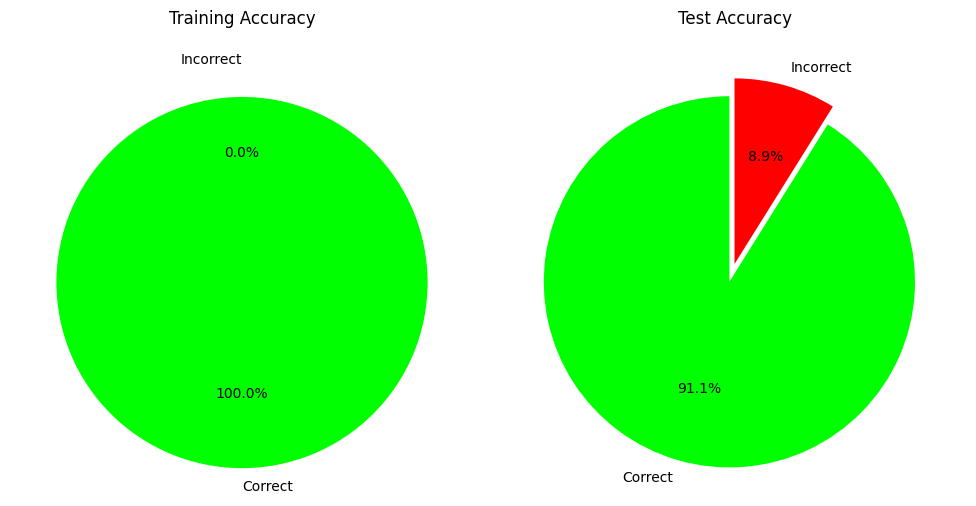

In [72]:
plot_accuracy_pies(train_acc_full, test_acc_full)

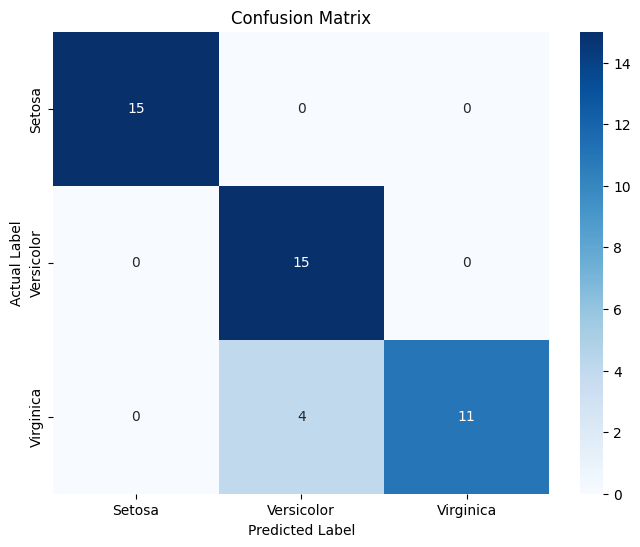

In [73]:
plot_confusion_matrix(y_true_full, y_pred_full, CLASS_NAMES)

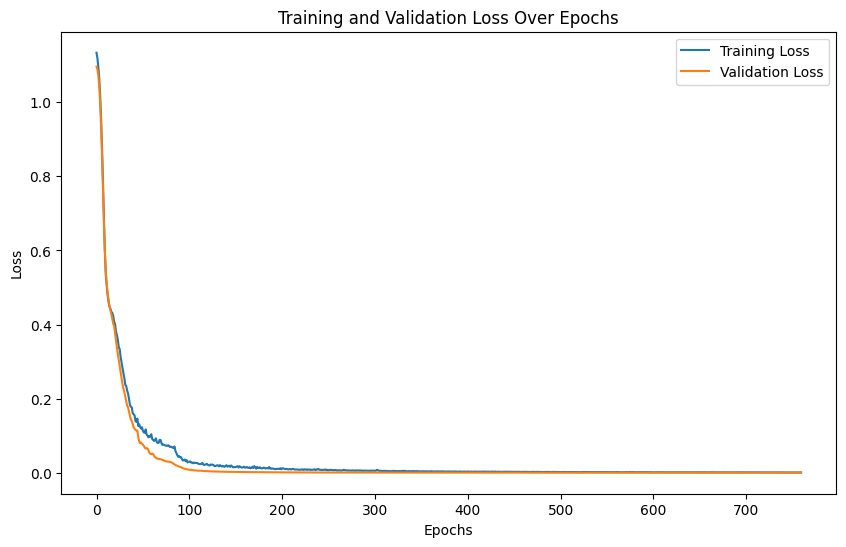

In [74]:
plot_loss_curves(train_losses_full, val_losses_full)

In [75]:
print(classification_report(y_true_full, y_pred_full, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  Versicolor       0.79      1.00      0.88        15
   Virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



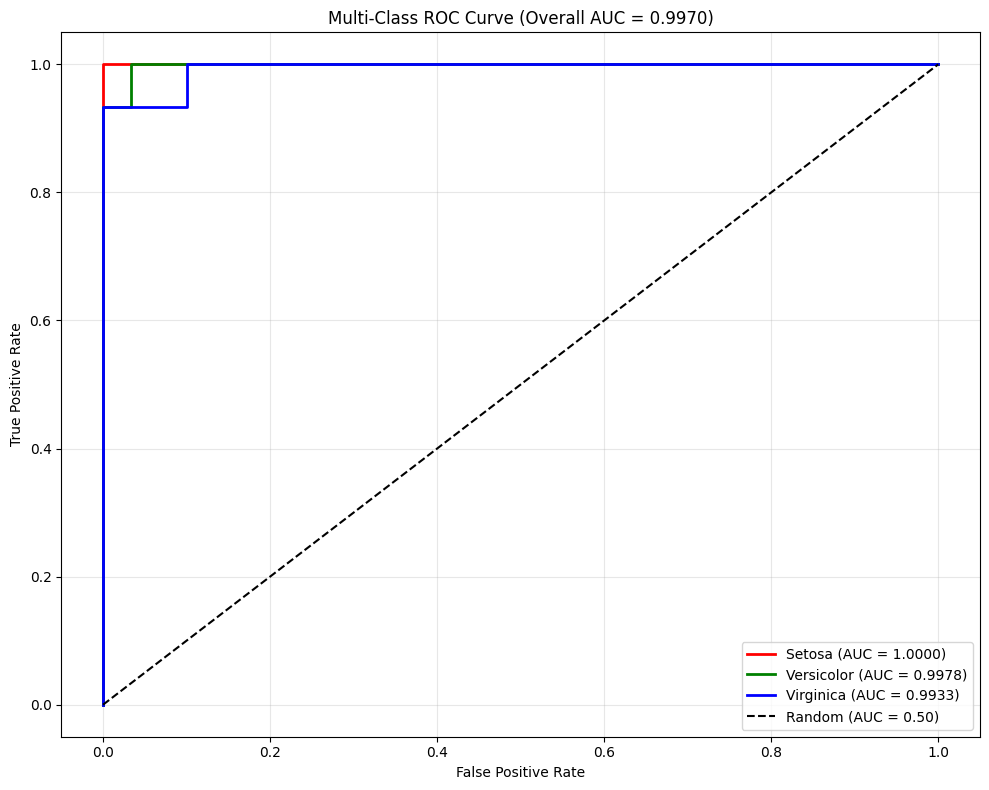

In [76]:
plot_roc_curves(y_true_full, y_probs_full, CLASS_NAMES)

In [77]:
print_summary_metrics(y_true_full, y_pred_full, y_probs_full)

------------------------------------------------------------------------------------------
METRIC          SCORE      DESCRIPTION
------------------------------------------------------------------------------------------
Accuracy        0.9111     Overall correctness (caution: misleading if imbalanced)
Precision       0.9298     When predicting positive, how often correct?
Recall          0.9111     Of all actual positives, how many found?
F1-Score        0.9095     Harmonic mean of Precision & Recall
ROC AUC         0.9970     Class separability (1.0 = perfect)
------------------------------------------------------------------------------------------


### SHAP Analysis — Full-Feature Model

  0%|          | 0/45 [00:00<?, ?it/s]

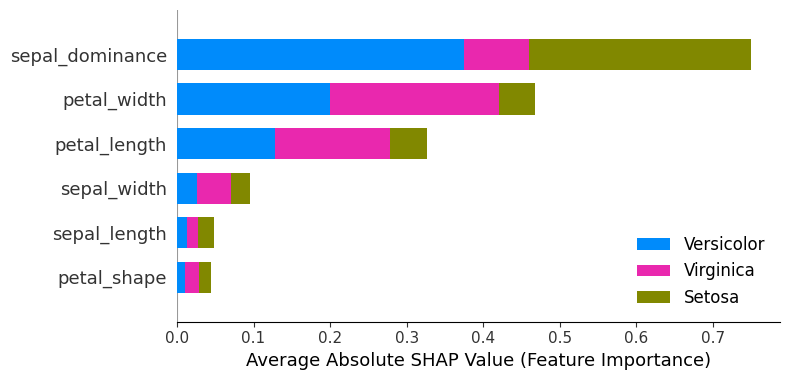

In [78]:
run_shap_analysis(model_full, X_tr_full, X_te_full, CLASS_NAMES, DEVICE)

## Lean-Feature Model (3 Features)

### Data Preparation & Training

In [79]:
# Select lean feature set based on discriminative score + domain knowledge
features_lean = ["sepal_dominance", "petal_width", "petal_length"]
X_tr_lean, X_val_lean, X_te_lean, y_tr_lean, y_val_lean, y_te_lean, scaler_lean = (
    prepare_data(df_train, df_test, features_lean, TARGET_VAR, VAL_SIZE, SEED)
)
train_loader_lean, val_loader_lean, test_loader_lean = create_loaders(
    X_tr_lean,
    X_val_lean,
    X_te_lean,
    y_tr_lean,
    y_val_lean,
    y_te_lean,
    DEVICE,
    BATCH_SIZE,
)
print(f"Features ({len(features_lean)}): {features_lean}")
print(f"Train: {len(y_tr_lean)}, Val: {len(y_val_lean)}, Test: {len(y_te_lean)}")

Features (3): ['sepal_dominance', 'petal_width', 'petal_length']
Train: 89, Val: 16, Test: 45


In [80]:
# Create and train the lean-feature model
model_lean = IrisMLP(
    in_features=len(features_lean),
    h1=H1,
    h2=H2,
    out_features=OUT_FEATURES,
    dropout=DROPOUT,
).to(DEVICE)
class_weights_lean = _compute_class_weights(y_tr_lean, DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights_lean)
optimizer = torch.optim.AdamW(model_lean.parameters(), lr=LR)
lean_config = {
    "epochs": EPOCHS,
    "log_interval": LOG_INTERVAL,
    "save_path": "iris_model_lean.pth",
    "patience": PATIENCE,
}
train_losses_lean, val_losses_lean, best_lean = train_model(
    model_lean, train_loader_lean, val_loader_lean, criterion, optimizer, lean_config
)
print(f"\nBest Validation Loss: {best_lean:.4f}")

Epoch 0/1000 - Train: 1.1037 - Val: 1.0816
Epoch 10/1000 - Train: 0.4595 - Val: 0.3949
Epoch 20/1000 - Train: 0.1058 - Val: 0.0388
Epoch 30/1000 - Train: 0.0662 - Val: 0.0105
Epoch 40/1000 - Train: 0.0599 - Val: 0.0065
Epoch 50/1000 - Train: 0.0545 - Val: 0.0055
Epoch 60/1000 - Train: 0.0562 - Val: 0.0054
Epoch 70/1000 - Train: 0.0531 - Val: 0.0035
Epoch 80/1000 - Train: 0.0605 - Val: 0.0061
Epoch 90/1000 - Train: 0.0542 - Val: 0.0045
Epoch 100/1000 - Train: 0.0594 - Val: 0.0055
Epoch 110/1000 - Train: 0.0568 - Val: 0.0037
Epoch 120/1000 - Train: 0.0550 - Val: 0.0043
Epoch 130/1000 - Train: 0.0527 - Val: 0.0031
Epoch 140/1000 - Train: 0.0530 - Val: 0.0040
Epoch 150/1000 - Train: 0.0557 - Val: 0.0041
Epoch 160/1000 - Train: 0.0574 - Val: 0.0050
Epoch 170/1000 - Train: 0.0559 - Val: 0.0029
Early stopping at epoch 173 (patience=50)

Best Validation Loss: 0.0025


### Evaluate Lean-Feature Model

In [81]:
# Collect predictions and compute accuracy
y_true_lean, y_pred_lean, y_probs_lean = collect_predictions(
    model_lean, test_loader_lean
)
train_acc_lean = accuracy_score(*collect_predictions(model_lean, train_loader_lean)[:2])
val_acc_lean = accuracy_score(*collect_predictions(model_lean, val_loader_lean)[:2])
test_acc_lean = accuracy_score(y_true_lean, y_pred_lean)
print(f"Train Accuracy: {train_acc_lean:.4f}")
print(f"Val Accuracy:   {val_acc_lean:.4f}")
print(f"Test Accuracy:  {test_acc_lean:.4f}")

Train Accuracy: 0.9663
Val Accuracy:   1.0000
Test Accuracy:  0.9333


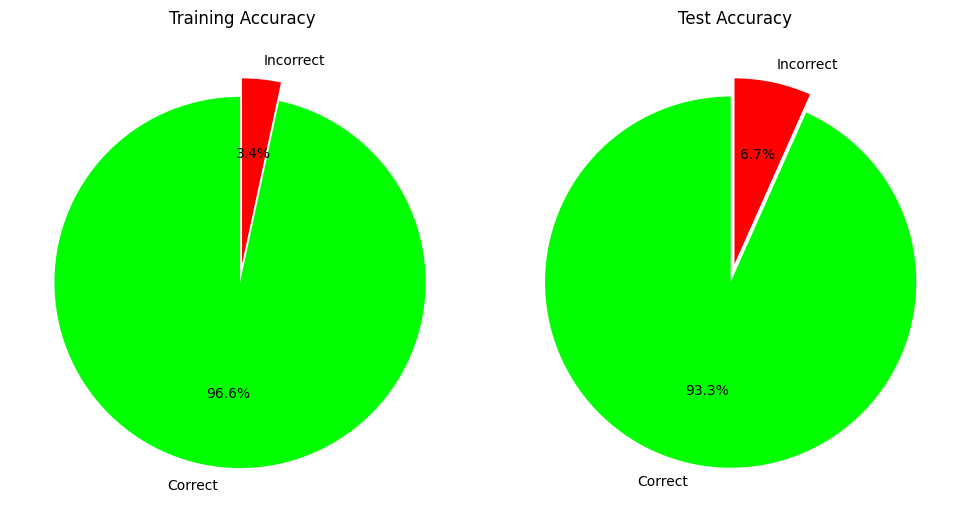

In [82]:
plot_accuracy_pies(train_acc_lean, test_acc_lean)

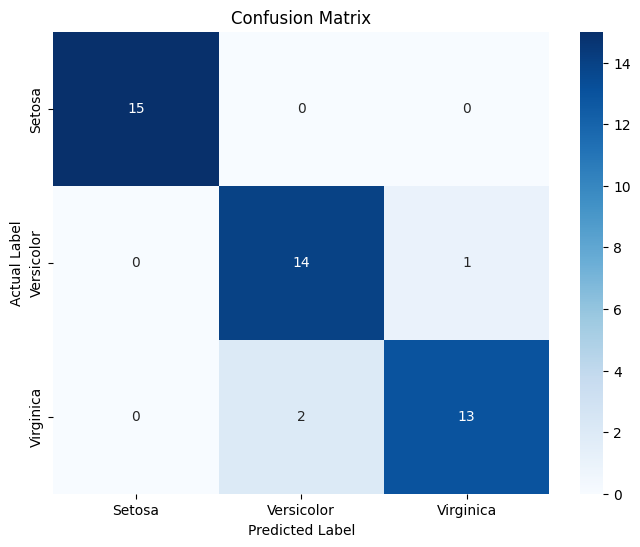

In [83]:
plot_confusion_matrix(y_true_lean, y_pred_lean, CLASS_NAMES)

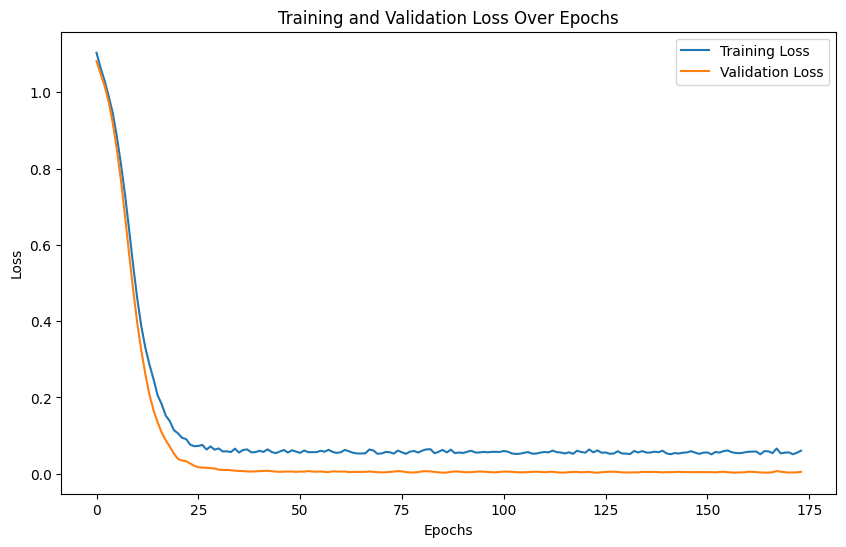

In [84]:
plot_loss_curves(train_losses_lean, val_losses_lean)

In [85]:
print(classification_report(y_true_lean, y_pred_lean, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  Versicolor       0.88      0.93      0.90        15
   Virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



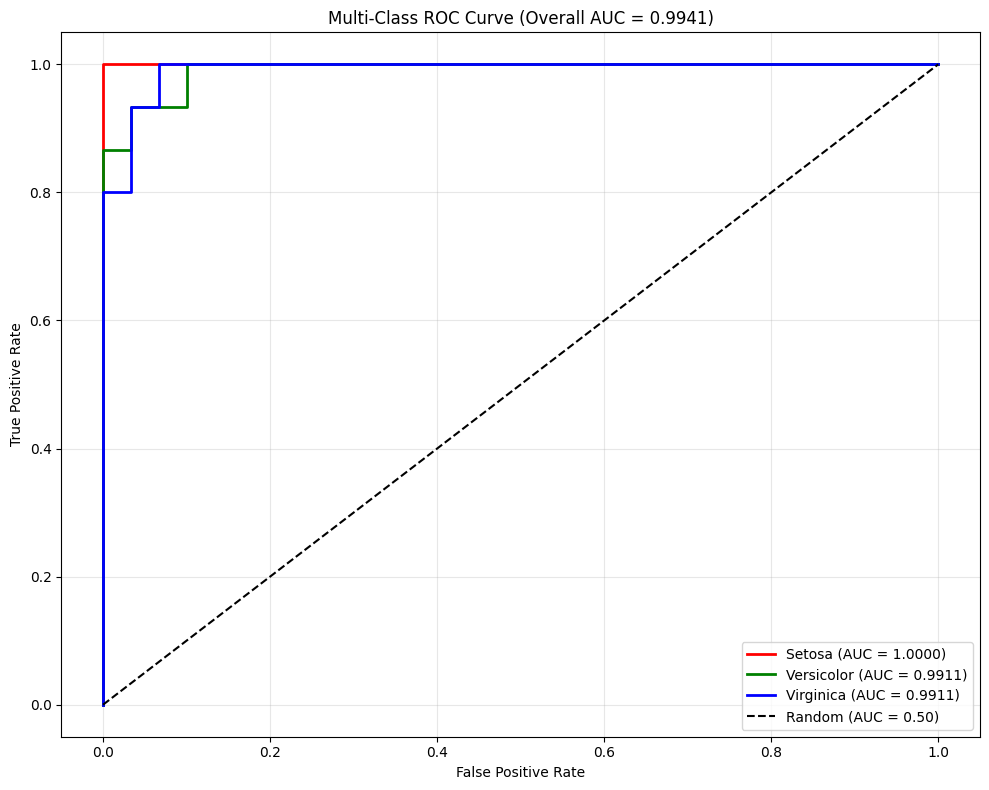

In [86]:
plot_roc_curves(y_true_lean, y_probs_lean, CLASS_NAMES)

In [87]:
print_summary_metrics(y_true_lean, y_pred_lean, y_probs_lean)

------------------------------------------------------------------------------------------
METRIC          SCORE      DESCRIPTION
------------------------------------------------------------------------------------------
Accuracy        0.9333     Overall correctness (caution: misleading if imbalanced)
Precision       0.9345     When predicting positive, how often correct?
Recall          0.9333     Of all actual positives, how many found?
F1-Score        0.9333     Harmonic mean of Precision & Recall
ROC AUC         0.9941     Class separability (1.0 = perfect)
------------------------------------------------------------------------------------------


### SHAP Analysis — Lean-Feature Model

  0%|          | 0/45 [00:00<?, ?it/s]

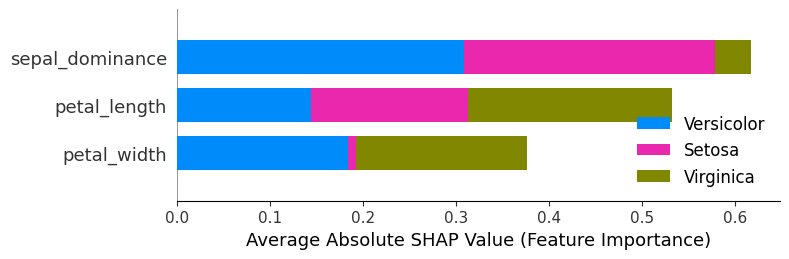

In [88]:
run_shap_analysis(model_lean, X_tr_lean, X_te_lean, CLASS_NAMES, DEVICE)

### Save Lean Model Artifacts

In [89]:
# Save lean model scaler for production inference
joblib.dump(scaler_lean, "iris_scaler.pkl")
print("Scaler Saved: 'iris_scaler.pkl'")

Scaler Saved: 'iris_scaler.pkl'


## Inference

### Load Model

In [90]:
loaded_model = IrisMLP(
    in_features=len(features_lean), h1=H1, h2=H2, out_features=OUT_FEATURES
).to(DEVICE)
loaded_model.load_state_dict(
    torch.load("iris_model_lean.pth", map_location=DEVICE, weights_only=True)
)
loaded_model.eval()
print("Model Loaded: 'iris_model_lean.pth'")

Model Loaded: 'iris_model_lean.pth'


### Load Scaler

In [91]:
scaler = joblib.load("iris_scaler.pkl")
print("Scaler Loaded: 'iris_scaler.pkl'")

Scaler Loaded: 'iris_scaler.pkl'


### Example: New Flower Measurements

In [92]:
# 1. Define Raw Data (matching features_lean order: sepal_dominance, petal_width, petal_length)
sepal_dominance = 1.0  # setosa IS sepal_dominant (sepal_length > 2*petal_length)
petal_width = 0.2  # small petal width -> setosa characteristic
petal_length = 1.4  # small petal length -> setosa characteristic
raw_flower = [sepal_dominance, petal_width, petal_length]

# 2. CRITICAL: Scale using the fitted scaler from training
scaled_flower = scaler.transform([raw_flower])

# 3. Predict using SCALED data
species, confidence = predict(loaded_model, scaled_flower[0], SPECIES_MAP, DEVICE)
print(f"Raw Input:         {raw_flower}")
print(f"Predicted Species: {species}")
print(f"Confidence:        {confidence:.2%}")

Raw Input:         [1.0, 0.2, 1.4]
Predicted Species: setosa
Confidence:        99.98%
